In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        count += 1

print(f"There are total {count} number of images.")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

There are total 5856 number of images.


#### Importing PyTorch

In [2]:
import torch
from torch import nn

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.1.2


#### Setting up device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")

Current device: cuda


#### Let's get to know about the data

Let's write a small helper function to ber able to walk through each subdirectories in our data storage structure and count the total number of files that we have for our problem.


In [4]:
import os
from pathlib import Path

def walk_through_directory(dir_path: Path):
    """
    Walks through the content of the directory and returning it.
    Args:
        dir_path (str or pathlib.Path): target_directory
        
    Return:
        A print out of:
          number of subdiretories in dir_path
          number of images (files) in each subdirectory
          name of each subdirectory
    """
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
data_path = Path("/kaggle/input/pneumonia-disease-dataset")
image_path = data_path / "chest_xray"

walk_through_directory(image_path)

There are 2 directories and 0 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray'.
There are 2 directories and 0 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray/test'.
There are 0 directories and 390 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray/test/NORMAL'.
There are 2 directories and 0 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray/train'.
There are 0 directories and 3883 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1349 images in '/kaggle/input/pneumonia-disease-dataset/chest_xray/train/NORMAL'.


In [6]:
## setting up the train and test path
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('/kaggle/input/pneumonia-disease-dataset/chest_xray/train'),
 PosixPath('/kaggle/input/pneumonia-disease-dataset/chest_xray/test'))

Visualize an image too see how it looks like

Random image path: /kaggle/input/pneumonia-disease-dataset/chest_xray/test/PNEUMONIA/VIRUS-7385225-0001.jpeg


(-0.5, 1119.5, 551.5, -0.5)

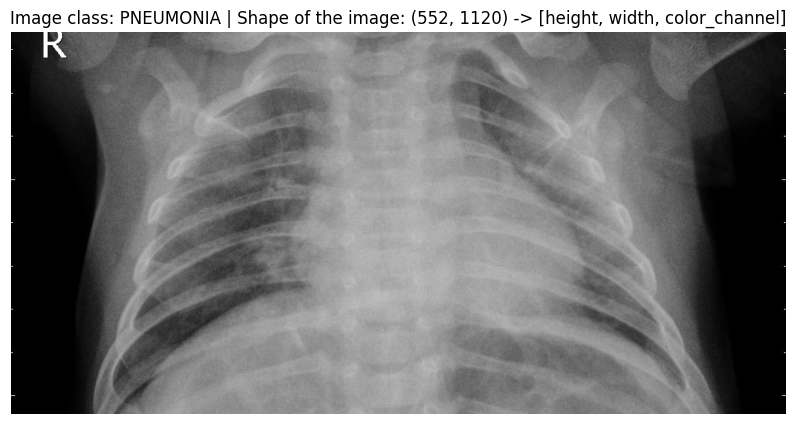

In [8]:
import random
from PIL import Image
import matplotlib.pyplot as plt

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class_name = random_image_path.parent.stem

img = Image.open(random_image_path)

img_array = np.asarray(img)

print(f"Random image path: {random_image_path}")

plt.figure(figsize=(10, 6))
plt.imshow(img_array, cmap="gray")
plt.title(f"Image class: {image_class_name} | Shape of the image: {img_array.shape} -> [height, width, color_channel]")
plt.axis(False)

#### Transforming out data to be compatible with PyTorch

In [9]:
## Getting necessory libraries
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Let's create to transform to apply upon images to see what happens.

In [44]:
data_transformation = transforms.Compose([
    ## Resize the images
    transforms.Resize(size=(512, 512)),
    ## Convert them into tensors
    transforms.ToTensor(),
    ## Convert RGB to Grayscale
    transforms.Grayscale(num_output_channels=1)
])

In [45]:
## Writing a function to apply the custom transform to set of images
def plot_transformed_images(image_paths, transform, n=4):
    """
    Plots the random set of images from the image_path.
    Will take the n images from image_paths and apply transformation.
    Also plot them side by side with their transformed version.
    
    Args:
        image_paths: List of images
        transform: transformation to be apply to images
        n: number of images to plot
    """
    
    random_images_path = random.sample(image_paths, k=n)
    
    for image_path in random_images_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            
            ax[0].imshow(f, cmap="gray")
            ax[0].set_title(f"original image\nsize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f)
            
            ax[1].imshow(transformed_image.permute(1, 2, 0), cmap="gray")
            ax[1].set_title(f"transformed image\nsize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class name: {image_path.parent.stem}")

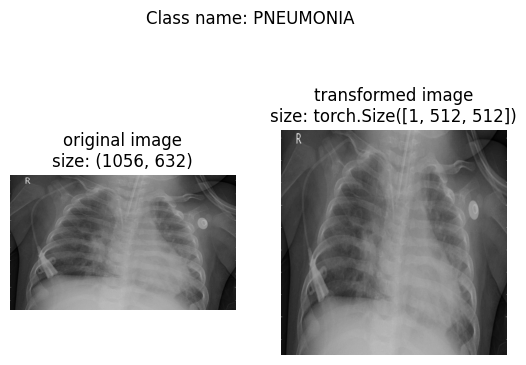

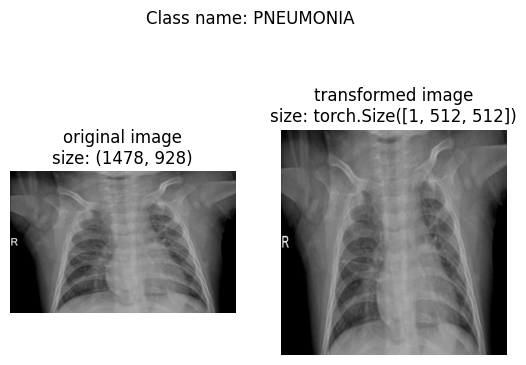

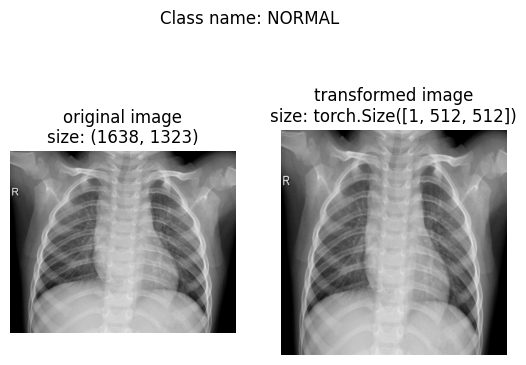

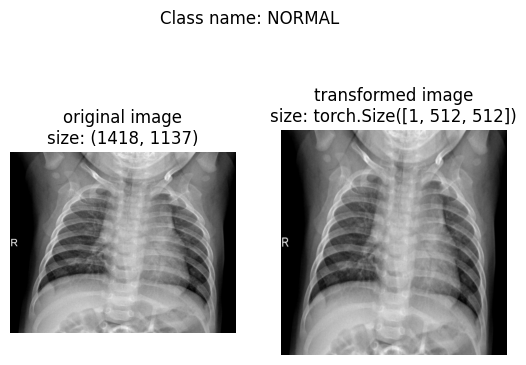

In [46]:
plot_transformed_images(image_paths=image_path_list, transform=data_transformation)

convert the data into PyTorch Dataset and then into DataLoader because it is more computationally effective.

In [47]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transformation,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transformation)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5232
     Root location: /kaggle/input/pneumonia-disease-dataset/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Grayscale(num_output_channels=1)
            ),
 Dataset ImageFolder
     Number of datapoints: 624
     Root location: /kaggle/input/pneumonia-disease-dataset/chest_xray/test
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Grayscale(num_output_channels=1)
            ))

In [48]:
## we cna get class names and their respective index by using in-built attributes
class_names = train_data.classes
class_to_index = train_data.class_to_idx

print(class_names, "\n")
print(class_to_index)

['NORMAL', 'PNEUMONIA'] 

{'NORMAL': 0, 'PNEUMONIA': 1}



Image tensor: 
tensor([[[0.3568, 0.3647, 0.3725,  ..., 0.6666, 0.6352, 0.5843],
         [0.3529, 0.3647, 0.3725,  ..., 0.6431, 0.5803, 0.4941],
         [0.3647, 0.3725, 0.3764,  ..., 0.5999, 0.4901, 0.3725],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
Image tensor shape: torch.Size([1, 512, 512])
Image tensor datatype: torch.float32
Label: 0
Label datatype: <class 'int'>


(-0.5, 511.5, 511.5, -0.5)

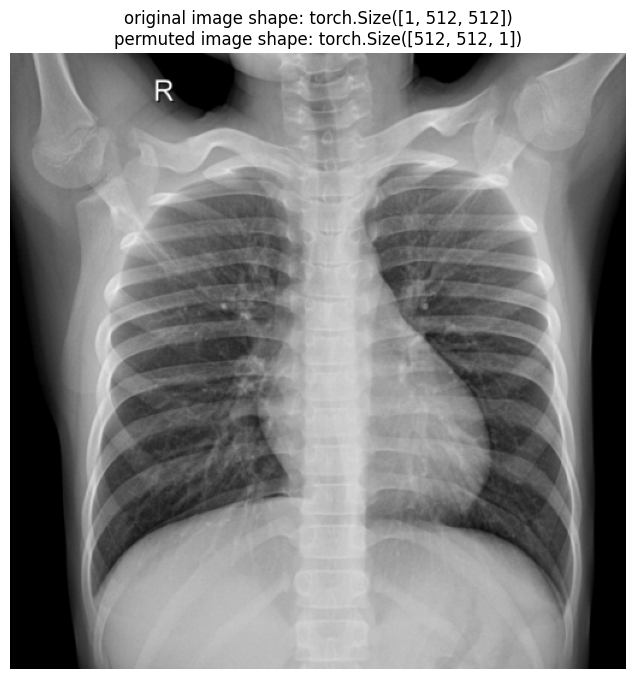

In [50]:
## Checking whether or not we'll able to get the data
image_tensor, label = train_data[0][0], train_data[0][1]

print(f"\nImage tensor: \n{image_tensor}")
print(f"Image tensor shape: {image_tensor.shape}")
print(f"Image tensor datatype: {image_tensor.dtype}")
print(f"Label: {label}")
print(f"Label datatype: {type(label)}")

img = image_tensor.permute(1, 2, 0)

plt.figure(figsize=(10, 8))
plt.imshow(img, cmap="gray")
plt.title(f"original image shape: {image_tensor.shape}\npermuted image shape: {img.shape}")
plt.axis(False)

In [51]:
## converting train and test datasets into DataLoaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc077b8aa10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc077b8a950>)

In [52]:
## Cheking whether or not are they created successfully
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 512, 512]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([32])


In [14]:
## Let's check it by displaying certain images
from typing import List

def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str],
    n: int = 5,
    display_shape: bool = True
):
    if n > 5:
        n = 5
        display_shape = False
        print(f"If you want to display the images then n should be less then or equal to {n}. converting it to n and removing the shape display.")
        
    random_images_index = random.sample(range(len(dataset)), k=n)
    
    plt.figure(figsize=(16, 8))
    
    for i, target_sample in enumerate(random_images_index):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

        target_image = target_image.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(target_image)
        plt.axis("off")
        if classes:
            title = f"class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {target_image.shape}"
        plt.title(title)

If you want to display the images then n should be less then or equal to 5. converting it to n and removing the shape display.


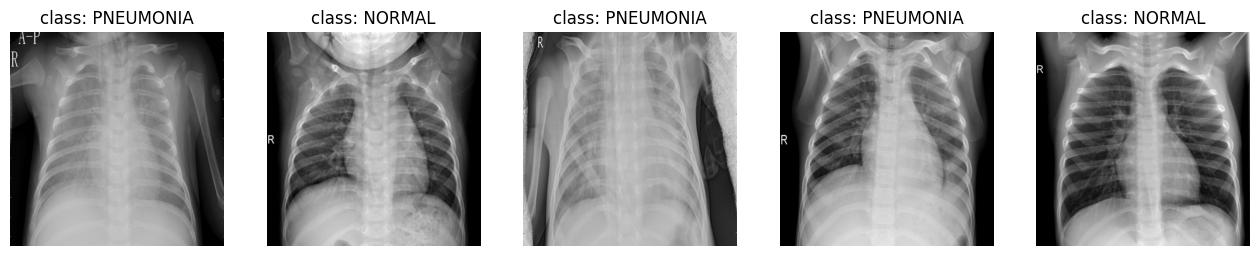

In [20]:
display_random_images(
    dataset=train_data,
    classes=class_names,
    n=10
)

#### Creating Model Class

In [15]:
class PneumoniaModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*128*128,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [18]:
pneumonia_model_v0 = PneumoniaModelV0(
    input_shape=3,
    hidden_units=4,
    output_shape=1
).to(device)

pneumonia_model_v0

PneumoniaModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=1, bias=True)
  )
)

Let's try to make prediction on single image to see the working of forward pass.

In [19]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

summary(pneumonia_model_v0, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV0                         [1, 1]                    --
├─Sequential: 1-1                        [1, 4, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 4, 512, 512]          112
│    └─ReLU: 2-2                         [1, 4, 512, 512]          --
│    └─Conv2d: 2-3                       [1, 4, 512, 512]          148
│    └─ReLU: 2-4                         [1, 4, 512, 512]          --
│    └─MaxPool2d: 2-5                    [1, 4, 256, 256]          --
├─Sequential: 1-2                        [1, 4, 128, 128]          --
│    └─Conv2d: 2-6                       [1, 4, 256, 256]          148
│    └─ReLU: 2-7                         [1, 4, 256, 256]          --
│    └─Conv2d: 2-8                       [1, 4, 256, 256]          148
│    └─ReLU: 2-9                         [1, 4, 256, 256]          --
│    └─MaxPool2d: 2-10                   [1, 4, 128, 128]          --
├─Sequentia

In [20]:
img_batch, label_batch = next(iter(train_dataloader))

image, label = img_batch[0].unsqueeze(dim = 0), label_batch[0]

print(f"Image shape: {image.shape}")

pneumonia_model_v0.eval()
with torch.inference_mode():
    pred = pneumonia_model_v0(image.to(device))
    
print(f"Prediction Logits: \n{pred}")
print(f"\nPrediction Probabilities: \n{torch.sigmoid(pred)}")
print(f"\nPrediction Label: {torch.round(torch.sigmoid(pred)).squeeze()}")
print(f"\nActual Label: {label}")

Image shape: torch.Size([1, 3, 512, 512])
Prediction Logits: 
tensor([[-0.0713]], device='cuda:0')

Prediction Probabilities: 
tensor([[0.4822]], device='cuda:0')

Prediction Label: 0.0

Actual Label: 0


In [21]:
image_batch, label_batch = next(iter(train_dataloader))

pneumonia_model_v0.eval()
with torch.inference_mode():
    
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)
    
    y_logits = pneumonia_model_v0(image_batch).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
print(f"Prediction Logits: \n{y_logits}\nShape: {y_logits.shape}\nDatatype: {y_logits.dtype}")
print(f"\nPrediction Class: \n{y_pred}\nShape: {y_pred.shape}\nDatatype: {y_pred.dtype}")
print(f"\nActual Class: \n{label_batch}\nShape: {label_batch.shape}\nDatatype: {label_batch.dtype}")

Prediction Logits: 
tensor([-0.0714, -0.0712, -0.0711, -0.0711, -0.0713, -0.0709, -0.0711, -0.0712,
        -0.0711, -0.0711, -0.0712, -0.0712, -0.0713, -0.0710, -0.0711, -0.0712,
        -0.0711, -0.0710, -0.0710, -0.0711, -0.0712, -0.0712, -0.0710, -0.0710,
        -0.0712, -0.0712, -0.0712, -0.0710, -0.0708, -0.0713, -0.0711, -0.0711],
       device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.float32

Prediction Class: 
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.float32

Actual Class: 
tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.int64


#### Defining training and testing steps to train the model

In [54]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fun,
):
    
    model.train()
    
    train_loss, train_accuracy = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        loss = loss_fun(y_logits, y.type(torch.float32))
        train_loss += loss.item()
        
        train_accuracy += accuracy_fun(y_true=y, y_pred=y_pred)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [55]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    accuracy_fun,
):
    
    model.eval()
    
    test_loss, test_accuracy = 0, 0
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            
            y_logits = model(X).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))
            
            loss = loss_fun(y_logits, y.type(torch.float32))
            test_loss += loss.item()
            test_accuracy += accuracy_fun(y_true=y, y_pred=y_pred)
            
    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)
        
    return test_loss, test_accuracy

In [56]:
from tqdm.auto import tqdm
from typing import Dict, List

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fun,
    epochs: int = 10
) -> Dict[str, List]:
    
    results = {
        "train_loss" : [],
        "train_accuracy" : [],
        "test_loss" : [],
        "test_accuracy" : []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fun = loss_fun,
            optimizer = optimizer,
            accuracy_fun = accuracy_fun
        )
        
        test_loss, test_accuracy = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_fun = loss_fun,
            accuracy_fun = accuracy_fun
        )
        
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} Train Accuracy {train_accuracy:.4f} | Test Loss {test_loss:.4f} Test Accuracy {test_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
    
    return results

In [25]:
## Defining loss function, accuracy function and optimizer
loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pneumonia_model_v0.parameters(), lr=0.001)

In [57]:
def accuracy_fun(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy_score = (correct / len(y_pred)) * 100
    return accuracy_score

In [28]:
## Starting the model training process 

EPOCHS = 10

from timeit import default_timer as timer

start_time = timer()

model_v0_results = train(
    model = pneumonia_model_v0,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.2285 Train Accuracy 90.4052 | Test Loss 0.4943 Test Accuracy 82.5321
Epoch 1 | Train Loss: 0.1131 Train Accuracy 95.6804 | Test Loss 0.4303 Test Accuracy 83.9744
Epoch 2 | Train Loss: 0.0820 Train Accuracy 96.9992 | Test Loss 0.5377 Test Accuracy 84.1346
Epoch 3 | Train Loss: 0.0750 Train Accuracy 96.9419 | Test Loss 0.8662 Test Accuracy 82.0513
Epoch 4 | Train Loss: 0.0469 Train Accuracy 98.3754 | Test Loss 0.5467 Test Accuracy 86.5385
Epoch 5 | Train Loss: 0.0332 Train Accuracy 98.8341 | Test Loss 0.8690 Test Accuracy 80.9295
Epoch 6 | Train Loss: 0.0254 Train Accuracy 99.2928 | Test Loss 0.9350 Test Accuracy 84.7756
Epoch 7 | Train Loss: 0.0137 Train Accuracy 99.4648 | Test Loss 1.5390 Test Accuracy 79.4872
Epoch 8 | Train Loss: 0.0177 Train Accuracy 99.3502 | Test Loss 0.7905 Test Accuracy 86.0577
Epoch 9 | Train Loss: 0.0180 Train Accuracy 99.2737 | Test Loss 1.1255 Test Accuracy 85.4167
Total training time: 611.8338973240002


In [58]:
def plot_loss_curves(a: Dict[str, List]):
    """
    Plotting the curve of loss and accuracy for the training process.
    
    Args:
        a (Dict[str, List]): result dictionary containing values
    """
    
    train_loss = a["train_loss"]
    test_loss = a["test_loss"]
    
    train_accuracy = a["train_accuracy"]
    test_accuracy = a["test_accuracy"]
    
    epochs = range(len(a["train_loss"]))
    
    plt.figure(figsize = (16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss Curves of the Training Process")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy Curves of the Training Process")
    plt.xlabel("Epochs")
    plt.legend()

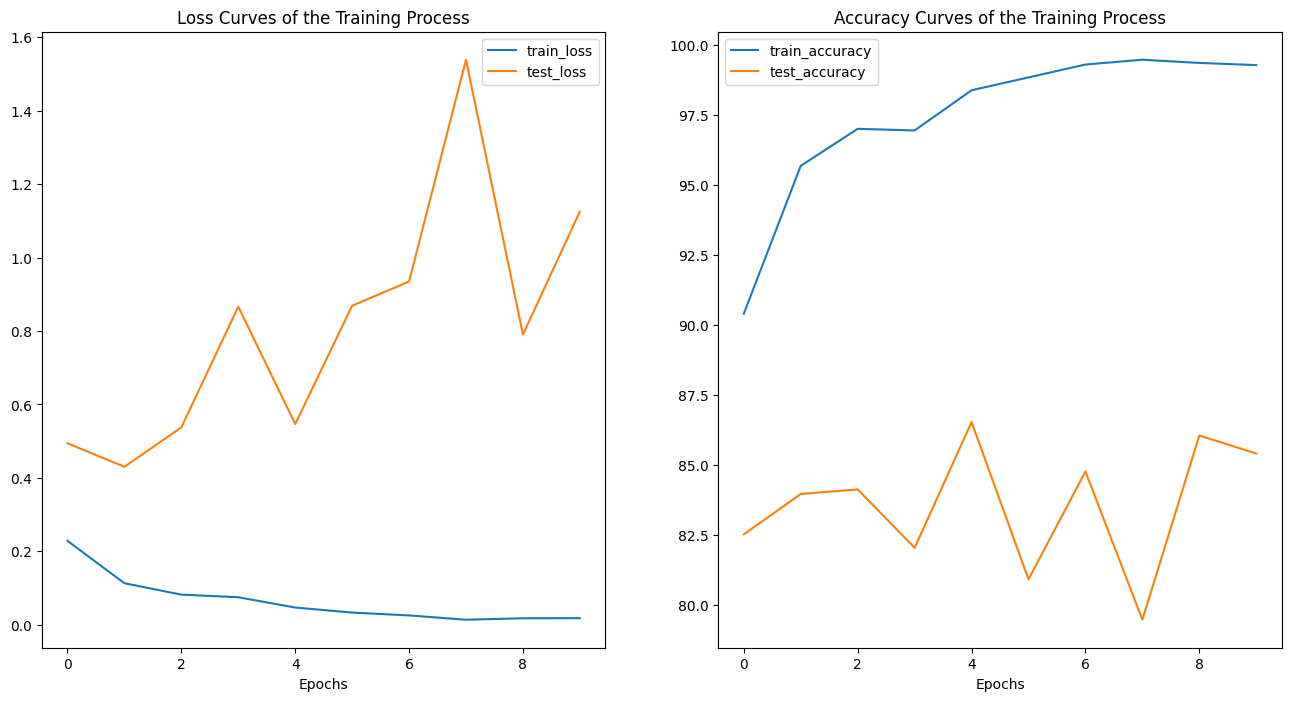

In [31]:
plot_loss_curves(model_v0_results)

By looking at the graph we can clearly get to know that our model is slightly overfitted. Slightly because we got the accuracy of around 86 which is a good indicator but I want it to be more than 95. So let's perform certain experiments to see if we can increase it or not.

We can't increase the number of epochs since our model already starts to overfit the data with 10 epochs.

Let's try to simplfy the model architecture by reducing the number of hidden layers or/and hidden units per layer.

In [27]:
class PneumoniaModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*256*256,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_1(x))

In [28]:
pneumonia_model_v1 = PneumoniaModelV1(
    input_shape = 3,
    hidden_units = 2,
    output_shape = 1
).to(device)

pneumonia_model_v1

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [29]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(pneumonia_model_v1, input_size = [1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-3                       [1, 2, 512, 512]          38
│    └─ReLU: 2-4                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-5                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-6                      [1, 131072]               --
│    └─Linear: 2-7                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (MB): 8.39
Params size (MB): 0.52
Estimated Total Size (MB): 12.06

In [54]:
## Starting the model training process 

EPOCHS = 10
optimizer = torch.optim.Adam(pneumonia_model_v1.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_v1_results = train(
    model = pneumonia_model_v1,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
) 

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.7911 Train Accuracy 69.5884 | Test Loss 0.6472 Test Accuracy 66.5625
Epoch 1 | Train Loss: 0.3202 Train Accuracy 85.8803 | Test Loss 0.2886 Test Accuracy 88.4375
Epoch 2 | Train Loss: 0.1417 Train Accuracy 94.4741 | Test Loss 0.2660 Test Accuracy 89.8438
Epoch 3 | Train Loss: 0.0946 Train Accuracy 96.6082 | Test Loss 0.3908 Test Accuracy 86.8750
Epoch 4 | Train Loss: 0.0680 Train Accuracy 97.6562 | Test Loss 0.4320 Test Accuracy 85.9375
Epoch 5 | Train Loss: 0.0480 Train Accuracy 98.3041 | Test Loss 0.7044 Test Accuracy 81.0938
Epoch 6 | Train Loss: 0.0371 Train Accuracy 98.7424 | Test Loss 0.7579 Test Accuracy 80.0000
Epoch 7 | Train Loss: 0.0236 Train Accuracy 99.3712 | Test Loss 0.6409 Test Accuracy 83.1250
Epoch 8 | Train Loss: 0.0118 Train Accuracy 99.8857 | Test Loss 0.5624 Test Accuracy 86.7188
Epoch 9 | Train Loss: 0.0080 Train Accuracy 99.9619 | Test Loss 0.8161 Test Accuracy 82.9688
Total training time: 591.5694563069992


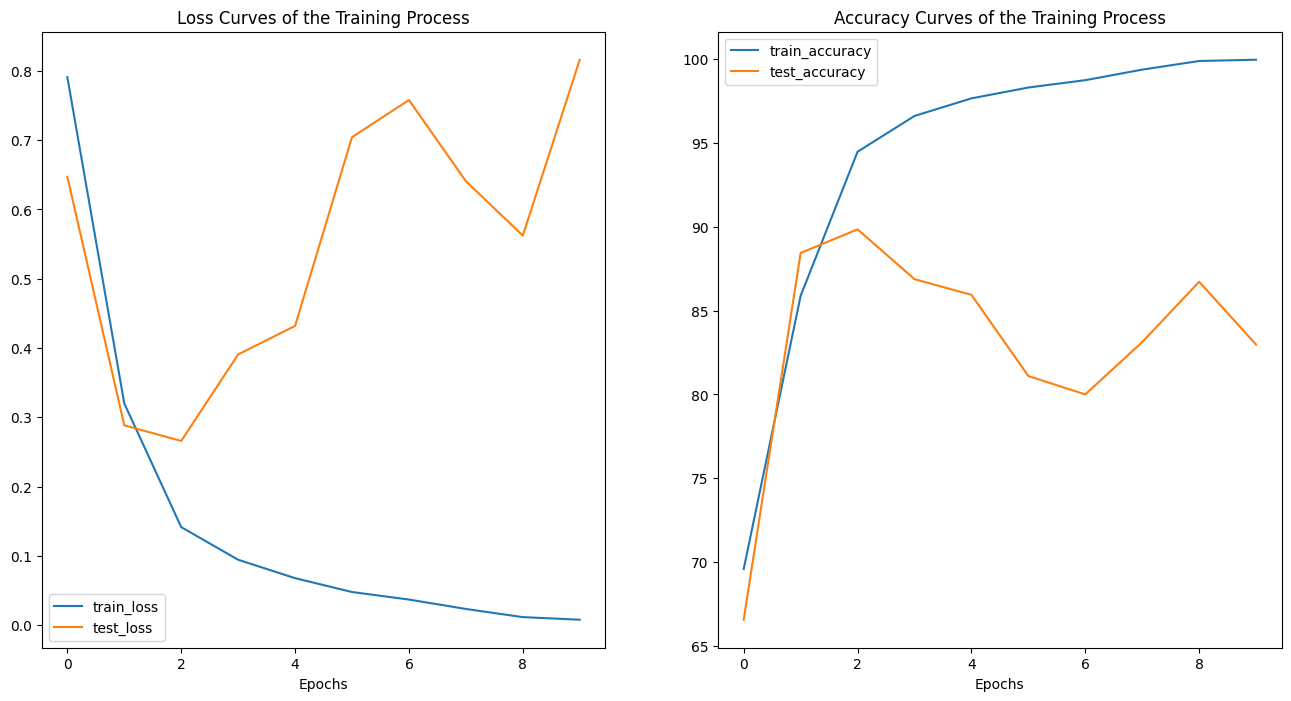

In [76]:
plot_loss_curves(model_v1_results)

We shouldn't keep number of epoch more than 5 because as it's clear that after 5 epoch model starts to overfit the data.

But for now let's just keep it as it is and try to use data augmentation to make it more harder for the model to learn because right now it overfits the data.

In [59]:
train_data_transformation = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

test_data_transformation = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

In [60]:
train_data_augmented = datasets.ImageFolder(root=train_path,
                                            transform=train_data_transformation,
                                            target_transform=None)

test_data_augmented = datasets.ImageFolder(root=test_path,
                                           transform=test_data_transformation)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 5232
     Root location: /kaggle/input/pneumonia-disease-dataset/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Grayscale(num_output_channels=1)
            ),
 Dataset ImageFolder
     Number of datapoints: 624
     Root location: /kaggle/input/pneumonia-disease-dataset/chest_xray/test
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Grayscale(num_output_channels=1)
            ))

In [61]:
## we cna get class names and their respective index by using in-built attributes
class_names = train_data_augmented.classes
class_to_index = train_data_augmented.class_to_idx

print(class_names, "\n")
print(class_to_index)

['NORMAL', 'PNEUMONIA'] 

{'NORMAL': 0, 'PNEUMONIA': 1}



Image tensor: 
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.5450, 0.5215, 0.4980],
         [0.0000, 0.0000, 0.0000,  ..., 0.5137, 0.4941, 0.4941],
         [0.0000, 0.0000, 0.0000,  ..., 0.4980, 0.4745, 0.4901],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
Image tensor shape: torch.Size([1, 512, 512])
Image tensor datatype: torch.float32
Label: 0
Label datatype: <class 'int'>


(-0.5, 511.5, 511.5, -0.5)

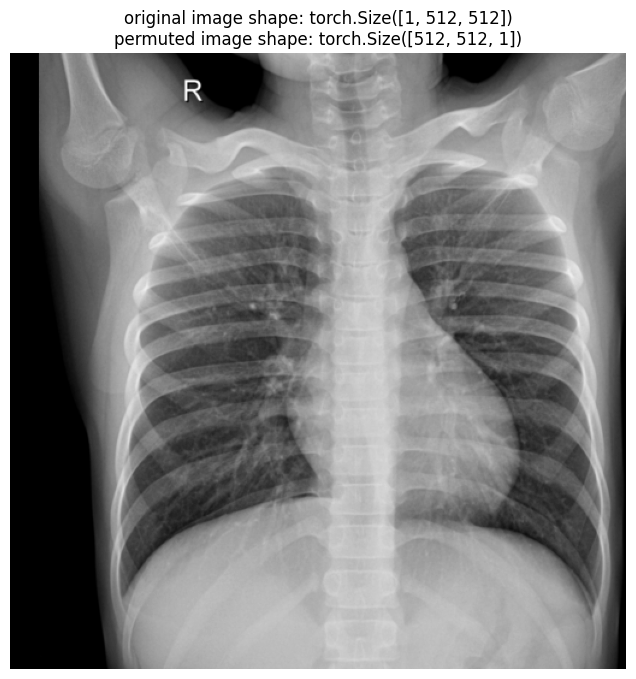

In [63]:
## Checking whether or not we'll able to get the data
image_tensor, label = train_data_augmented[0][0], train_data_augmented[0][1]

print(f"\nImage tensor: \n{image_tensor}")
print(f"Image tensor shape: {image_tensor.shape}")
print(f"Image tensor datatype: {image_tensor.dtype}")
print(f"Label: {label}")
print(f"Label datatype: {type(label)}")

img = image_tensor.permute(1, 2, 0)

plt.figure(figsize=(10, 8))
plt.imshow(img, cmap="gray")
plt.title(f"original image shape: {image_tensor.shape}\npermuted image shape: {img.shape}")
plt.axis(False)

In [64]:
## converting train and test datasets into DataLoaders
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True,
)

test_dataloader_augmented = DataLoader(
    dataset=test_data_augmented,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7fc07cd75f60>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc07cd75570>)

In [65]:
## Cheking whether or not are they created successfully
img, label = next(iter(train_dataloader_augmented))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 512, 512]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([32])


In [36]:
pneumonia_model_v2 = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v2

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [37]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

summary(pneumonia_model_v2, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-3                       [1, 2, 512, 512]          38
│    └─ReLU: 2-4                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-5                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-6                      [1, 131072]               --
│    └─Linear: 2-7                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (MB): 8.39
Params size (MB): 0.52
Estimated Total Size (MB): 12.06

In [38]:
img_batch, label_batch = next(iter(train_dataloader_augmented))

image, label = img_batch[0].unsqueeze(dim = 0), label_batch[0]

print(f"Image shape: {image.shape}")

pneumonia_model_v2.eval()
with torch.inference_mode():
    pred = pneumonia_model_v2(image.to(device))
    
print(f"Prediction Logits: \n{pred}")
print(f"\nPrediction Probabilities: \n{torch.sigmoid(pred)}")
print(f"\nPrediction Label: {torch.round(torch.sigmoid(pred)).squeeze()}")
print(f"\nActual Label: {label}")

Image shape: torch.Size([1, 3, 512, 512])
Prediction Logits: 
tensor([[-0.0179]], device='cuda:0')

Prediction Probabilities: 
tensor([[0.4955]], device='cuda:0')

Prediction Label: 0.0

Actual Label: 1


In [39]:
## Modifying optimizer
optimizer = torch.optim.Adam(pneumonia_model_v2.parameters(), lr=0.001)

In [68]:
## Starting the model training process 

EPOCHS = 10

from timeit import default_timer as timer

start_time = timer()

model_v2_results = train(
    model = pneumonia_model_v2,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.8443 Train Accuracy 69.1311 | Test Loss 0.6854 Test Accuracy 63.4375
Epoch 1 | Train Loss: 0.5436 Train Accuracy 74.9047 | Test Loss 0.7425 Test Accuracy 47.1875
Epoch 2 | Train Loss: 0.4274 Train Accuracy 81.1738 | Test Loss 0.3752 Test Accuracy 82.9688
Epoch 3 | Train Loss: 0.3630 Train Accuracy 85.5373 | Test Loss 0.3042 Test Accuracy 87.5000
Epoch 4 | Train Loss: 0.3352 Train Accuracy 86.0518 | Test Loss 0.4246 Test Accuracy 80.9375
Epoch 5 | Train Loss: 0.3364 Train Accuracy 87.0617 | Test Loss 0.3193 Test Accuracy 87.1875
Epoch 6 | Train Loss: 0.3162 Train Accuracy 87.8811 | Test Loss 0.3753 Test Accuracy 82.6562
Epoch 7 | Train Loss: 0.3062 Train Accuracy 88.3765 | Test Loss 0.3692 Test Accuracy 83.7500
Epoch 8 | Train Loss: 0.3209 Train Accuracy 87.6524 | Test Loss 0.3425 Test Accuracy 85.4688
Epoch 9 | Train Loss: 0.3107 Train Accuracy 87.9954 | Test Loss 0.3091 Test Accuracy 87.5000
Total training time: 663.7913161089991


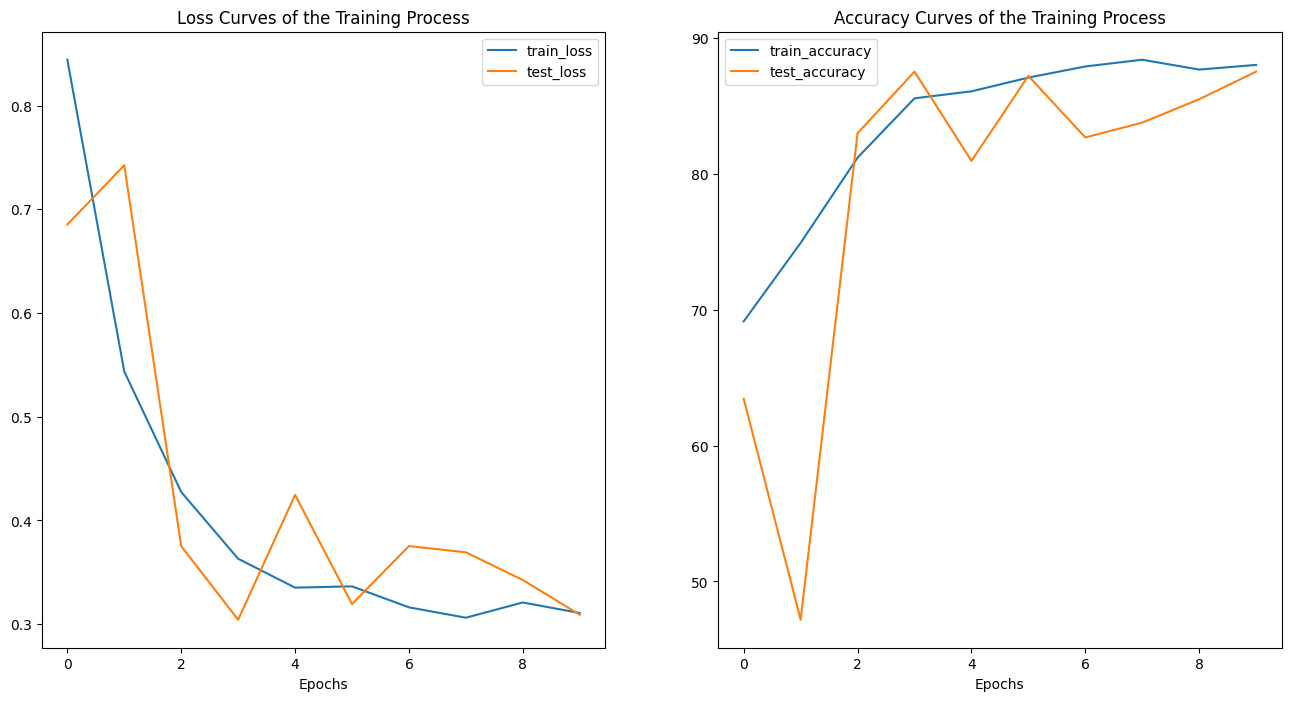

In [77]:
plot_loss_curves(model_v2_results)

It looks good because we were able to achieve accuracy score of 88 and 87 on training and testing dataset respectively.

Let's try to run it for more number of epochs and see what happens.

In [40]:
pneumonia_model_v3 = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v3

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [41]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

summary(pneumonia_model_v3, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-3                       [1, 2, 512, 512]          38
│    └─ReLU: 2-4                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-5                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-6                      [1, 131072]               --
│    └─Linear: 2-7                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (MB): 8.39
Params size (MB): 0.52
Estimated Total Size (MB): 12.06

In [42]:
## Modifying optimizer
optimizer = torch.optim.Adam(pneumonia_model_v3.parameters(), lr=0.001)

In [73]:
## Starting the model training process 

EPOCHS = 25

from timeit import default_timer as timer

start_time = timer()

model_v3_results = train(
    model = pneumonia_model_v3,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.4439 Train Accuracy 80.0305 | Test Loss 0.3781 Test Accuracy 79.8438
Epoch 1 | Train Loss: 0.2778 Train Accuracy 88.6052 | Test Loss 0.4071 Test Accuracy 79.0625
Epoch 2 | Train Loss: 0.2175 Train Accuracy 91.1014 | Test Loss 0.4320 Test Accuracy 82.1875
Epoch 3 | Train Loss: 0.2087 Train Accuracy 91.6921 | Test Loss 0.2990 Test Accuracy 87.3438
Epoch 4 | Train Loss: 0.2161 Train Accuracy 91.1014 | Test Loss 0.4132 Test Accuracy 82.5000
Epoch 5 | Train Loss: 0.1777 Train Accuracy 92.6448 | Test Loss 0.2799 Test Accuracy 89.5312
Epoch 6 | Train Loss: 0.1703 Train Accuracy 93.4451 | Test Loss 0.3791 Test Accuracy 87.3438
Epoch 7 | Train Loss: 0.1763 Train Accuracy 92.9116 | Test Loss 0.5128 Test Accuracy 81.4062
Epoch 8 | Train Loss: 0.1784 Train Accuracy 93.0450 | Test Loss 0.5528 Test Accuracy 80.1562
Epoch 9 | Train Loss: 0.1815 Train Accuracy 93.0259 | Test Loss 0.4521 Test Accuracy 83.5938
Epoch 10 | Train Loss: 0.1871 Train Accuracy 92.7782 | Test Loss 0.468

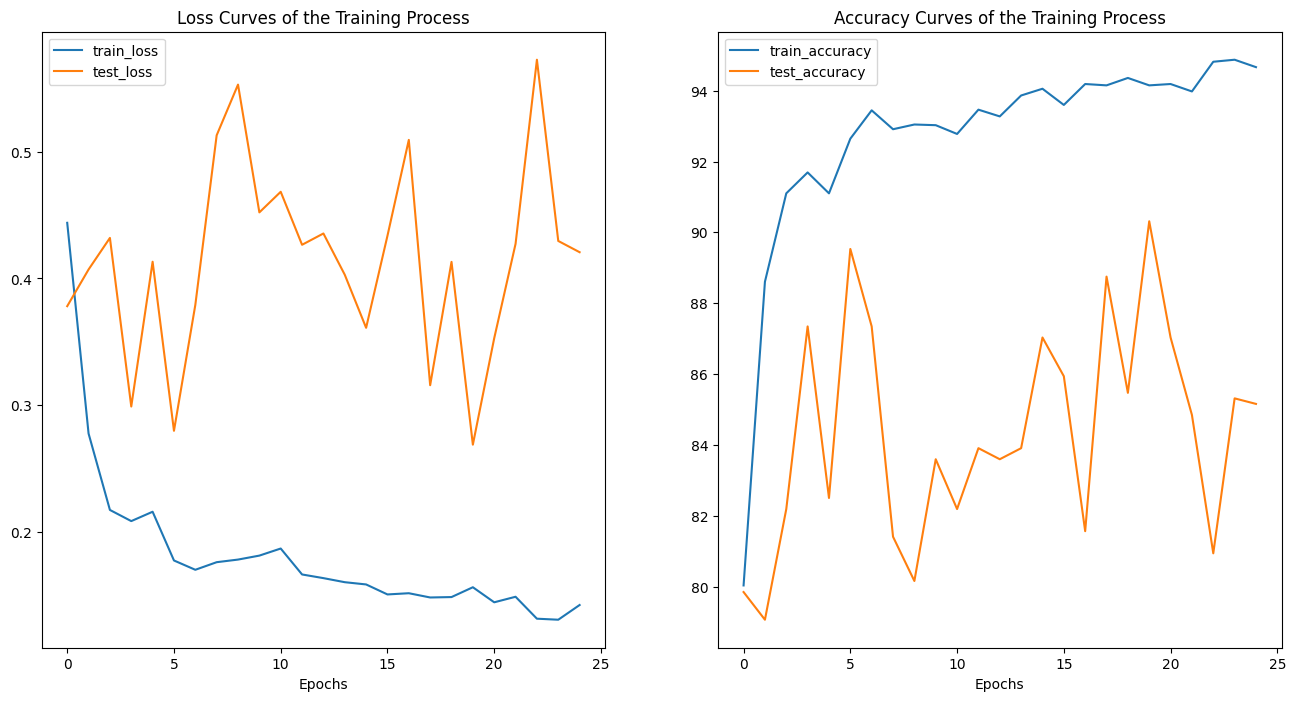

In [78]:
plot_loss_curves(model_v3_results)

Wohh, model is performing well. Let's try out some other things.

Here are the two things that came in my mind:
- Change in the learning rate (It is not related to model architecture)
- Dropout Layers (Related to model architecuture)

Let's find out what'll gonna happen if we add dropout layers in our model. We'll do it on both our model v1 and v3.

In [43]:
class PneumoniaModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Dropout2d(p=0.3),
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*256*256,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_1(x))

In [44]:
pneumonia_model_v1_with_dropout = PneumoniaModelV1(
    input_shape = 3,
    hidden_units = 2,
    output_shape = 1
).to(device)

pneumonia_model_v1_with_dropout

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [45]:
summary(pneumonia_model_v1_with_dropout, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Dropout2d: 2-1                    [1, 3, 512, 512]          --
│    └─Conv2d: 2-2                       [1, 2, 512, 512]          56
│    └─ReLU: 2-3                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-4                       [1, 2, 512, 512]          38
│    └─ReLU: 2-5                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-6                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-7                      [1, 131072]               --
│    └─Linear: 2-8                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (M

In [44]:
## Starting the model training process 

EPOCHS = 10
optimizer = torch.optim.Adam(pneumonia_model_v1_with_dropout.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_v1_with_dropout_results = train(
    model = pneumonia_model_v1_with_dropout,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.4011 Train Accuracy 85.4992 | Test Loss 0.3536 Test Accuracy 84.8438
Epoch 1 | Train Loss: 0.1930 Train Accuracy 92.9878 | Test Loss 0.8002 Test Accuracy 74.8438
Epoch 2 | Train Loss: 0.1934 Train Accuracy 92.5114 | Test Loss 1.0033 Test Accuracy 72.8125
Epoch 3 | Train Loss: 0.1679 Train Accuracy 93.6357 | Test Loss 0.6293 Test Accuracy 80.3125
Epoch 4 | Train Loss: 0.1656 Train Accuracy 93.3498 | Test Loss 0.4721 Test Accuracy 83.5938
Epoch 5 | Train Loss: 0.1497 Train Accuracy 94.0549 | Test Loss 0.5862 Test Accuracy 80.1562
Epoch 6 | Train Loss: 0.1414 Train Accuracy 94.3788 | Test Loss 0.7825 Test Accuracy 78.5938
Epoch 7 | Train Loss: 0.1487 Train Accuracy 94.2645 | Test Loss 0.5456 Test Accuracy 82.5000
Epoch 8 | Train Loss: 0.1251 Train Accuracy 95.2363 | Test Loss 0.7853 Test Accuracy 78.7500
Epoch 9 | Train Loss: 0.1188 Train Accuracy 95.5030 | Test Loss 0.7822 Test Accuracy 79.5312
Total training time: 579.1358757859998


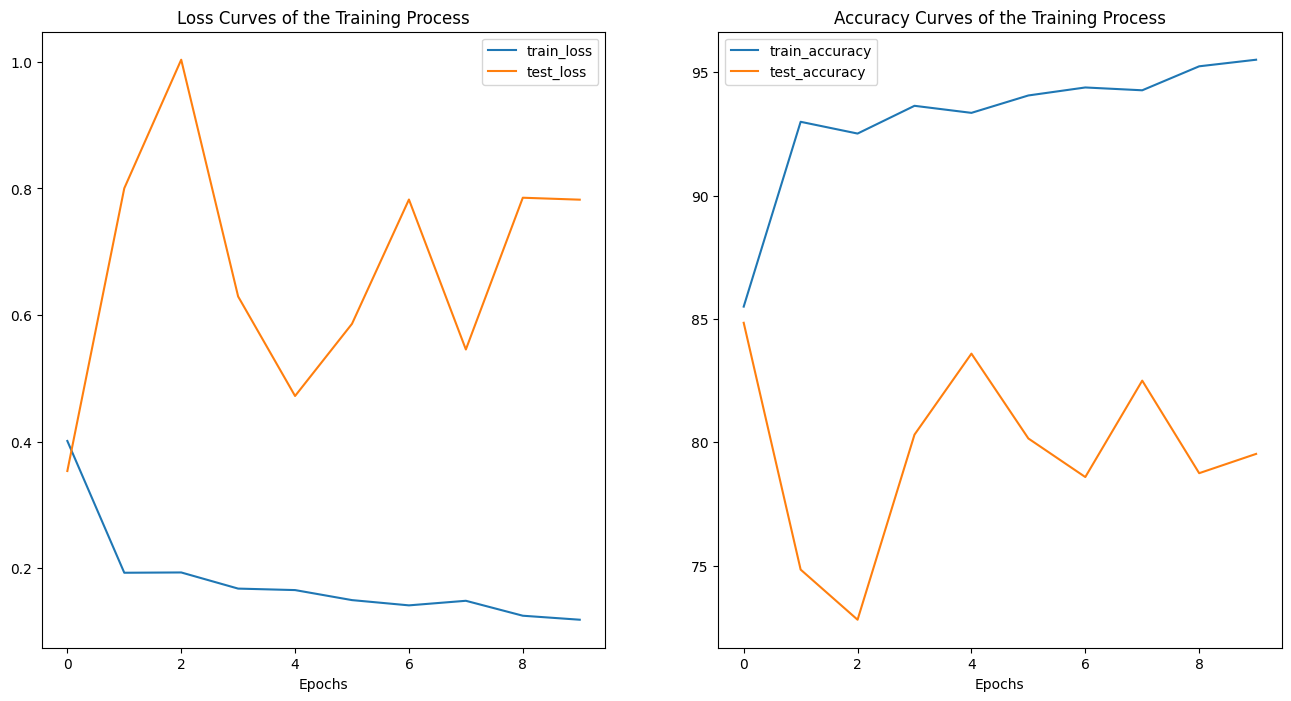

In [45]:
plot_loss_curves(model_v1_with_dropout_results)

In [46]:
pneumonia_model_v2_with_dropout = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v2_with_dropout

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [47]:
summary(pneumonia_model_v2_with_dropout, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Dropout2d: 2-1                    [1, 3, 512, 512]          --
│    └─Conv2d: 2-2                       [1, 2, 512, 512]          56
│    └─ReLU: 2-3                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-4                       [1, 2, 512, 512]          38
│    └─ReLU: 2-5                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-6                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-7                      [1, 131072]               --
│    └─Linear: 2-8                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (M

In [49]:
## Starting the model training process 

EPOCHS = 20
optimizer = torch.optim.Adam(pneumonia_model_v2_with_dropout.parameters(), lr=0.001)
from timeit import default_timer as timer

start_time = timer()

model_v2_with_dropout_results = train(
    model = pneumonia_model_v2_with_dropout,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

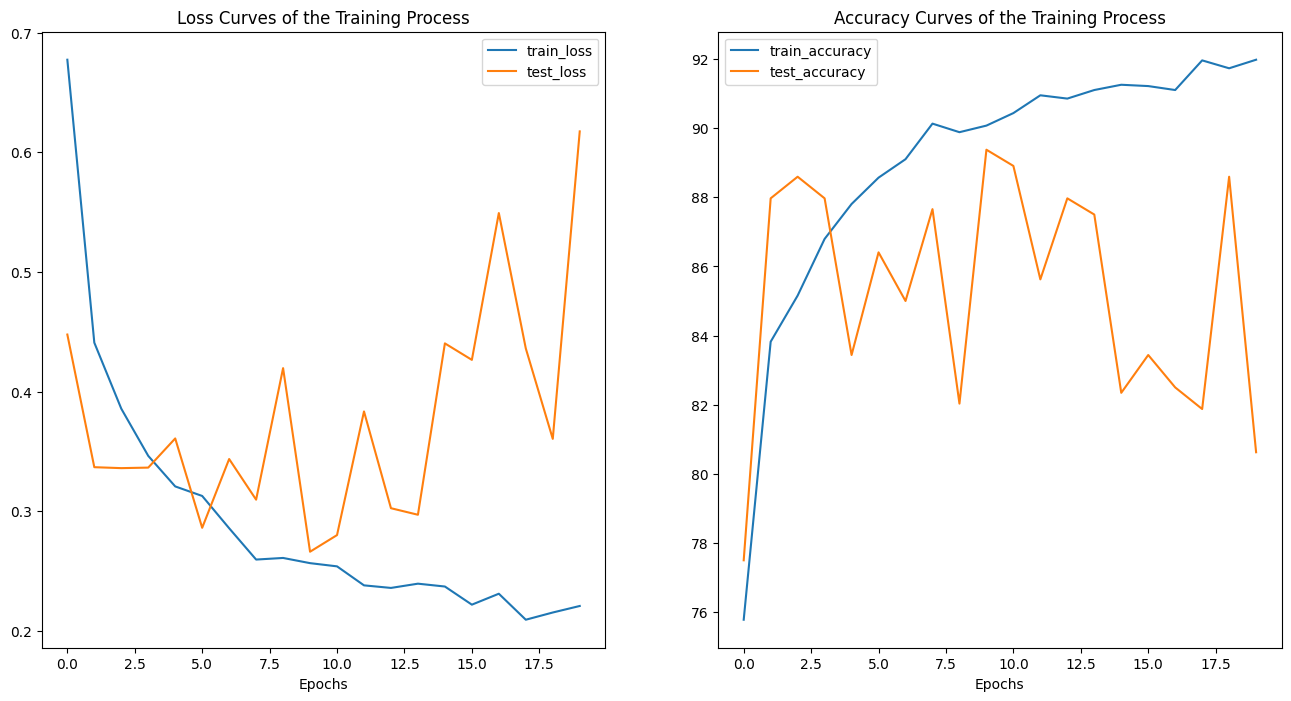

In [45]:
plot_loss_curves(model_v2_with_dropout_results)

I have already tries it by placing Dropout2D layer in between hidden layers but I won't get the desired result so in the above mentioned code I have placed it before inital layer to see if it works or not.

But it seems like adding Dropout2D layers won't work better.

Let's reduce one more layer and see what happen.

In [50]:
class PneumoniaModelV2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*256*256,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_1(x))

In [51]:
pneumonia_model_v4 = PneumoniaModelV2(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v4

PneumoniaModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [52]:
summary(pneumonia_model_v4, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV2                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-3                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-4                      [1, 131072]               --
│    └─Linear: 2-5                       [1, 1]                    131,073
Total params: 131,129
Trainable params: 131,129
Non-trainable params: 0
Total mult-adds (M): 14.81
Input size (MB): 3.15
Forward/backward pass size (MB): 4.19
Params size (MB): 0.52
Estimated Total Size (MB): 7.86

In [60]:
## Starting the model training process 

EPOCHS = 10
optimizer = torch.optim.Adam(pneumonia_model_v4.parameters(), lr=0.001)
from timeit import default_timer as timer

start_time = timer()

model_v4_results = train(
    model = pneumonia_model_v4,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.3059 Train Accuracy 87.5381 | Test Loss 0.5240 Test Accuracy 80.9375
Epoch 1 | Train Loss: 0.1097 Train Accuracy 96.1890 | Test Loss 0.6704 Test Accuracy 82.1875
Epoch 2 | Train Loss: 0.0849 Train Accuracy 96.8559 | Test Loss 0.6233 Test Accuracy 82.3438
Epoch 3 | Train Loss: 0.0704 Train Accuracy 97.7706 | Test Loss 0.4864 Test Accuracy 80.0000
Epoch 4 | Train Loss: 0.0619 Train Accuracy 97.7706 | Test Loss 0.3450 Test Accuracy 84.0625
Epoch 5 | Train Loss: 0.0421 Train Accuracy 98.6662 | Test Loss 0.4698 Test Accuracy 86.7188
Epoch 6 | Train Loss: 0.0385 Train Accuracy 98.8758 | Test Loss 0.4595 Test Accuracy 89.3750
Epoch 7 | Train Loss: 0.0336 Train Accuracy 99.1806 | Test Loss 0.6040 Test Accuracy 84.3750
Epoch 8 | Train Loss: 0.0220 Train Accuracy 99.3712 | Test Loss 0.5117 Test Accuracy 86.5625
Epoch 9 | Train Loss: 0.0195 Train Accuracy 99.5617 | Test Loss 0.6645 Test Accuracy 85.9375
Total training time: 576.1278257779995


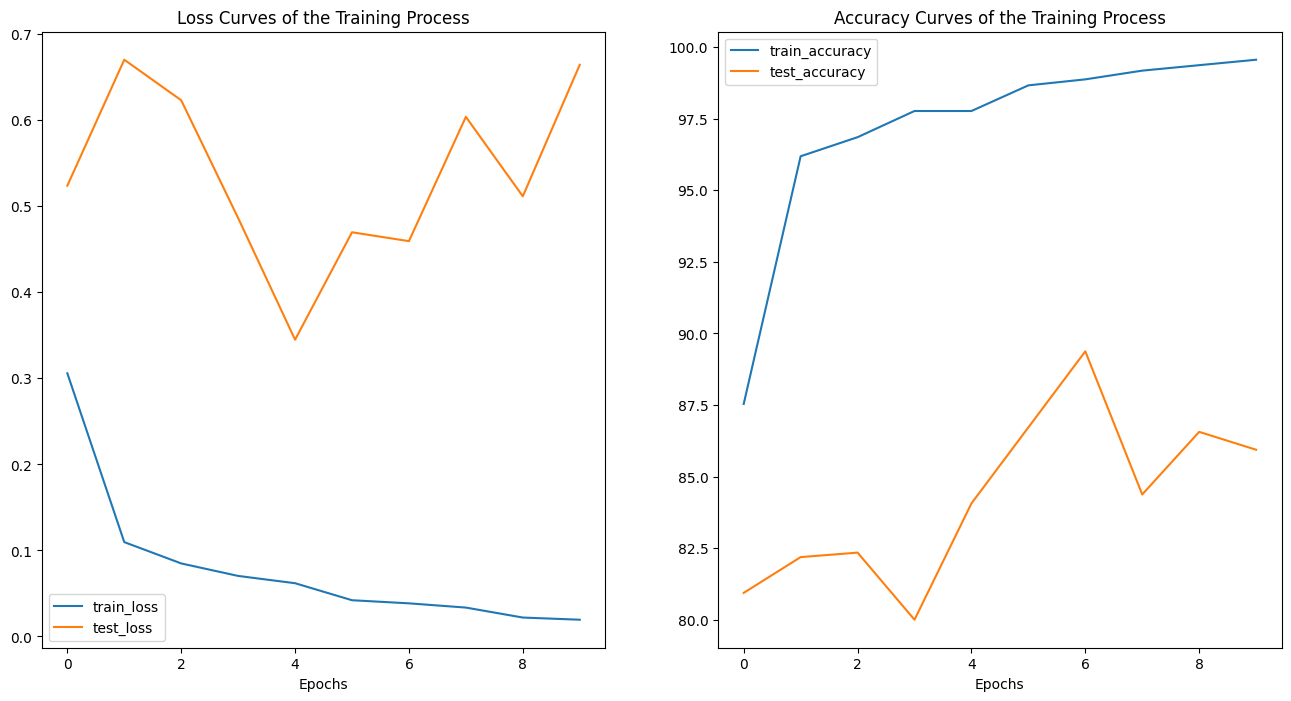

In [61]:
plot_loss_curves(model_v4_results)

In [53]:
pneumonia_model_v5 = PneumoniaModelV2(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v5

PneumoniaModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [54]:
summary(pneumonia_model_v5, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV2                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-3                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-4                      [1, 131072]               --
│    └─Linear: 2-5                       [1, 1]                    131,073
Total params: 131,129
Trainable params: 131,129
Non-trainable params: 0
Total mult-adds (M): 14.81
Input size (MB): 3.15
Forward/backward pass size (MB): 4.19
Params size (MB): 0.52
Estimated Total Size (MB): 7.86

In [64]:
EPOCHS = 10
optimizer = torch.optim.Adam(pneumonia_model_v5.parameters(), lr=0.001)
from timeit import default_timer as timer

start_time = timer()

model_v5_results = train(
    model = pneumonia_model_v5,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.6596 Train Accuracy 74.7332 | Test Loss 0.4003 Test Accuracy 81.5625
Epoch 1 | Train Loss: 0.3268 Train Accuracy 87.1761 | Test Loss 0.2568 Test Accuracy 89.3750
Epoch 2 | Train Loss: 0.2637 Train Accuracy 89.3483 | Test Loss 0.4388 Test Accuracy 79.3750
Epoch 3 | Train Loss: 0.2499 Train Accuracy 89.9009 | Test Loss 0.3391 Test Accuracy 85.9375
Epoch 4 | Train Loss: 0.2379 Train Accuracy 90.0724 | Test Loss 0.2849 Test Accuracy 88.1250
Epoch 5 | Train Loss: 0.2363 Train Accuracy 89.9390 | Test Loss 0.4641 Test Accuracy 80.1562
Epoch 6 | Train Loss: 0.2107 Train Accuracy 91.6159 | Test Loss 0.4656 Test Accuracy 81.2500
Epoch 7 | Train Loss: 0.2123 Train Accuracy 91.5015 | Test Loss 0.3842 Test Accuracy 85.0000
Epoch 8 | Train Loss: 0.1897 Train Accuracy 92.2256 | Test Loss 0.4746 Test Accuracy 80.7812
Epoch 9 | Train Loss: 0.1998 Train Accuracy 91.7683 | Test Loss 0.2792 Test Accuracy 89.3750
Total training time: 627.7746306049994


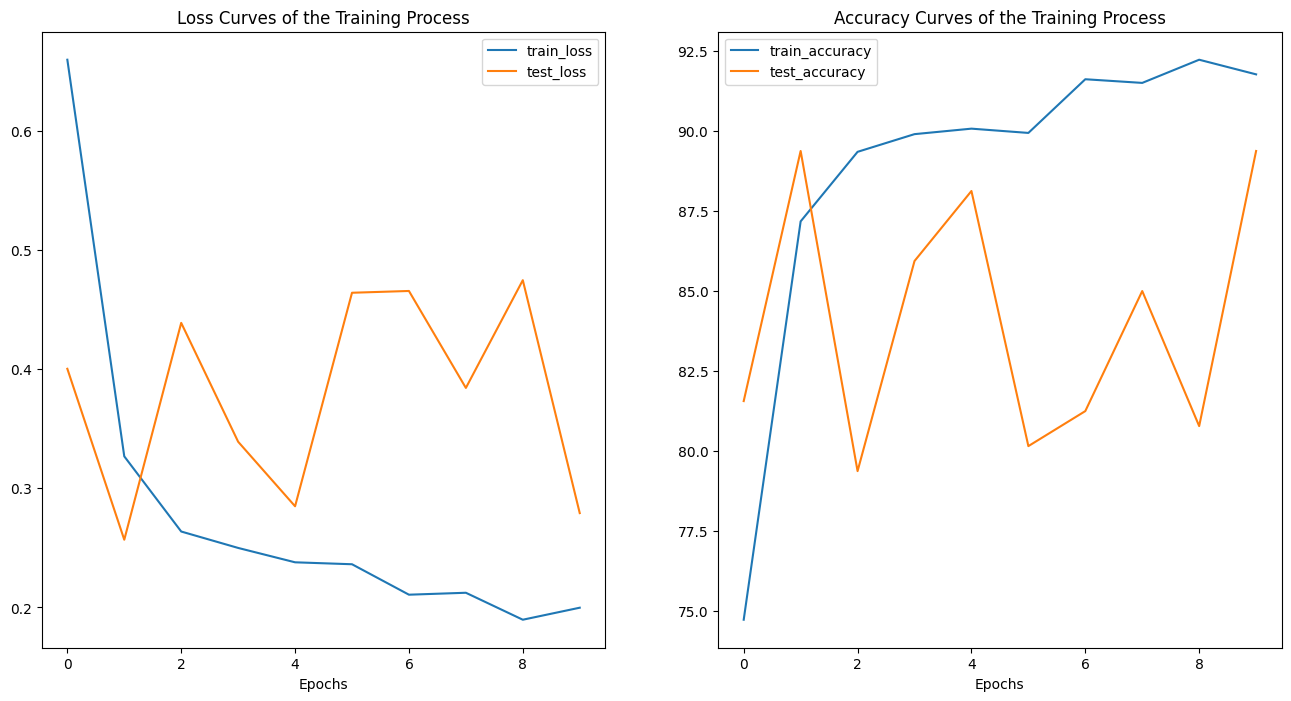

In [65]:
plot_loss_curves(model_v5_results)

Let's change the value of learning rate to see if we'll get the better result or not.

In [66]:
from tqdm.auto import tqdm
from typing import Dict, List

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fun,
    epochs: int = 10
) -> Dict[str, List]:
    
    results = {
        "train_loss" : [],
        "train_accuracy" : [],
        "test_loss" : [],
        "test_accuracy" : []
    }
    
    best_test_accuracy = float(0)
    best_epoch = 0
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fun = loss_fun,
            optimizer = optimizer,
            accuracy_fun = accuracy_fun
        )
        
        test_loss, test_accuracy = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_fun = loss_fun,
            accuracy_fun = accuracy_fun
        )
        
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} Train Accuracy {train_accuracy:.4f} | Test Loss {test_loss:.4f} Test Accuracy {test_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch = epoch
            
            torch.save({
                "epoch" : best_epoch,
                "model_state_dict" : model.state_dict(),
                "optimizer_state_dict" : optimizer.state_dict(),
                "test_accuracy" : best_test_accuracy
            }, "model.pth")
            
    
    print(f"\nTraining completed.\nBest model has been found at epoch {best_epoch + 1} with test accuracy of {best_test_accuracy}.\nModel saved successfully!")
    
    return results

In [67]:
from tqdm.auto import tqdm
from typing import Dict, List
from torch.optim.lr_scheduler import StepLR

def train_with_scheduler(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fun,
    epochs: int = 10
) -> Dict[str, List]:
    
    results = {
        "train_loss" : [],
        "train_accuracy" : [],
        "test_loss" : [],
        "test_accuracy" : []
    }
    
    scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.5)
    best_test_accuracy = float(0)
    best_epoch = 0
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fun = loss_fun,
            optimizer = optimizer,
            accuracy_fun = accuracy_fun
        )
        
        test_loss, test_accuracy = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_fun = loss_fun,
            accuracy_fun = accuracy_fun
        )
        
        current_learning_rate = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} Train Accuracy {train_accuracy:.4f} | Test Loss {test_loss:.4f} Test Accuracy {test_accuracy:.4f} | Learning Rate {current_learning_rate}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch = epoch
            
            torch.save({
                "epoch" : best_epoch,
                "model_state_dict" : model.state_dict(),
                "optimizer_state_dict" : optimizer.state_dict(),
                "test_accuracy" : best_test_accuracy
            }, "model.pth")
            
        scheduler.step()
            
    print(f"\nTraining completed.\nBest model has been found at epoch {best_epoch + 1} with test accuracy of {best_test_accuracy}.\nModel saved successfully!")
    
    return results

In [44]:
pneumonia_model_v2_with_scheduler = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v2_with_scheduler

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [45]:
from torchinfo import summary

summary(pneumonia_model_v2_with_scheduler, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-3                       [1, 2, 512, 512]          38
│    └─ReLU: 2-4                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-5                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-6                      [1, 131072]               --
│    └─Linear: 2-7                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (MB): 8.39
Params size (MB): 0.52
Estimated Total Size (MB): 12.06

In [46]:
EPOCHS = 15
loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pneumonia_model_v2_with_scheduler.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_v2_with_scheduler_results = train_with_scheduler(
    model = pneumonia_model_v2_with_scheduler,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.6117 Train Accuracy 83.3841 | Test Loss 0.3831 Test Accuracy 83.2812 | Learning Rate 0.001
Epoch 1 | Train Loss: 0.1886 Train Accuracy 92.6258 | Test Loss 0.4133 Test Accuracy 82.9688 | Learning Rate 0.001
Epoch 2 | Train Loss: 0.1448 Train Accuracy 94.7218 | Test Loss 0.3127 Test Accuracy 88.2812 | Learning Rate 0.001
Epoch 3 | Train Loss: 0.1076 Train Accuracy 95.8460 | Test Loss 0.2996 Test Accuracy 88.5938 | Learning Rate 0.001
Epoch 4 | Train Loss: 0.0867 Train Accuracy 96.8941 | Test Loss 0.5479 Test Accuracy 83.7500 | Learning Rate 0.001
Epoch 5 | Train Loss: 0.0642 Train Accuracy 97.6372 | Test Loss 0.7999 Test Accuracy 79.8438 | Learning Rate 0.001
Epoch 6 | Train Loss: 0.0713 Train Accuracy 97.5610 | Test Loss 0.5813 Test Accuracy 83.2812 | Learning Rate 0.001
Epoch 7 | Train Loss: 0.0552 Train Accuracy 98.0183 | Test Loss 0.6210 Test Accuracy 83.2812 | Learning Rate 0.001
Epoch 8 | Train Loss: 0.0339 Train Accuracy 99.1235 | Test Loss 0.5321 Test Accu

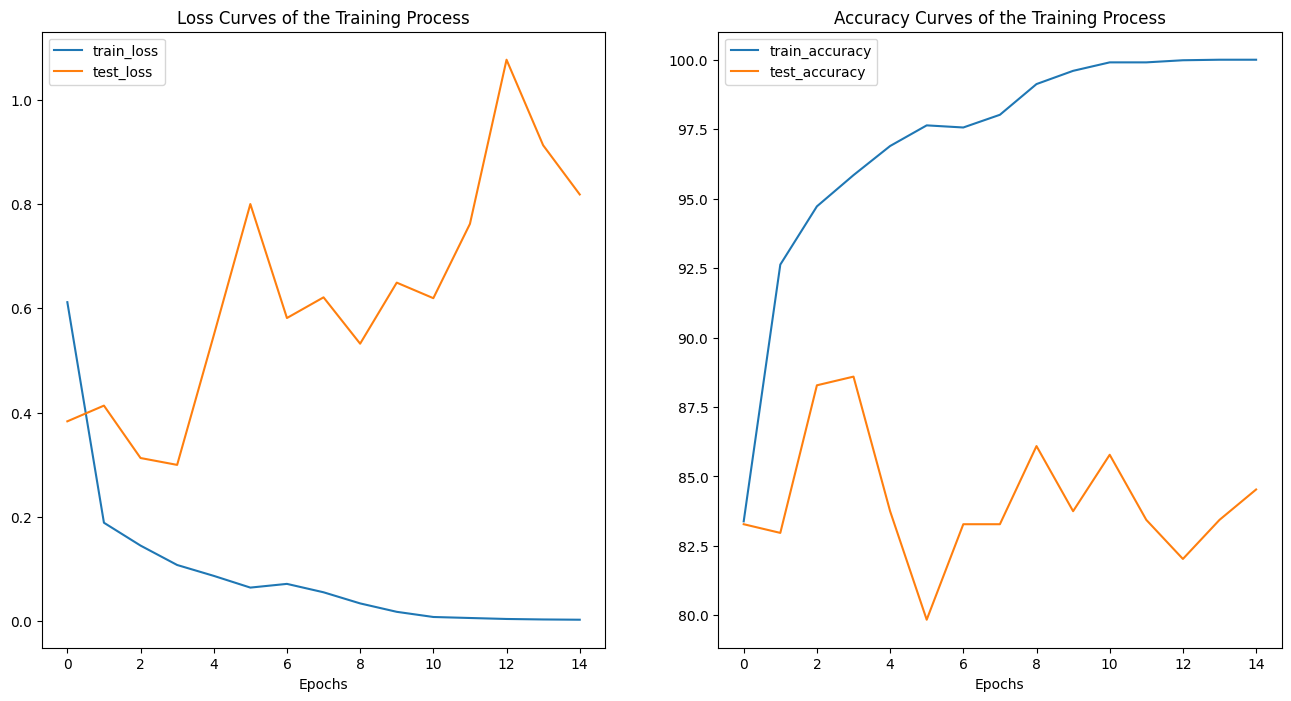

In [47]:
plot_loss_curves(model_v2_with_scheduler_results)

In [48]:
pneumonia_model_v3_with_scheduler = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v3_with_scheduler

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [49]:
summary(pneumonia_model_v3_with_scheduler, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─ReLU: 2-2                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-3                       [1, 2, 512, 512]          38
│    └─ReLU: 2-4                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-5                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-6                      [1, 131072]               --
│    └─Linear: 2-7                       [1, 1]                    131,073
Total params: 131,167
Trainable params: 131,167
Non-trainable params: 0
Total mult-adds (M): 24.77
Input size (MB): 3.15
Forward/backward pass size (MB): 8.39
Params size (MB): 0.52
Estimated Total Size (MB): 12.06

In [50]:
EPOCHS = 20
optimizer = torch.optim.Adam(pneumonia_model_v3_with_scheduler.parameters(), lr=0.001)
from timeit import default_timer as timer

start_time = timer()

model_v3_with_scheduler_results = train_with_scheduler(
    model = pneumonia_model_v3_with_scheduler,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.8448 Train Accuracy 75.6860 | Test Loss 0.5867 Test Accuracy 68.4375 | Learning Rate 0.001
Epoch 1 | Train Loss: 0.3148 Train Accuracy 87.4619 | Test Loss 0.2274 Test Accuracy 91.4062 | Learning Rate 0.001
Epoch 2 | Train Loss: 0.2573 Train Accuracy 89.5579 | Test Loss 0.2414 Test Accuracy 89.8438 | Learning Rate 0.001
Epoch 3 | Train Loss: 0.2424 Train Accuracy 90.0915 | Test Loss 0.5586 Test Accuracy 75.6250 | Learning Rate 0.001
Epoch 4 | Train Loss: 0.2262 Train Accuracy 91.1204 | Test Loss 0.3087 Test Accuracy 88.7500 | Learning Rate 0.001
Epoch 5 | Train Loss: 0.2078 Train Accuracy 91.7873 | Test Loss 0.4579 Test Accuracy 82.3438 | Learning Rate 0.001
Epoch 6 | Train Loss: 0.2054 Train Accuracy 92.1113 | Test Loss 0.3076 Test Accuracy 87.3438 | Learning Rate 0.001
Epoch 7 | Train Loss: 0.2025 Train Accuracy 91.8255 | Test Loss 0.5550 Test Accuracy 81.2500 | Learning Rate 0.001
Epoch 8 | Train Loss: 0.1735 Train Accuracy 93.3498 | Test Loss 0.4531 Test Accu

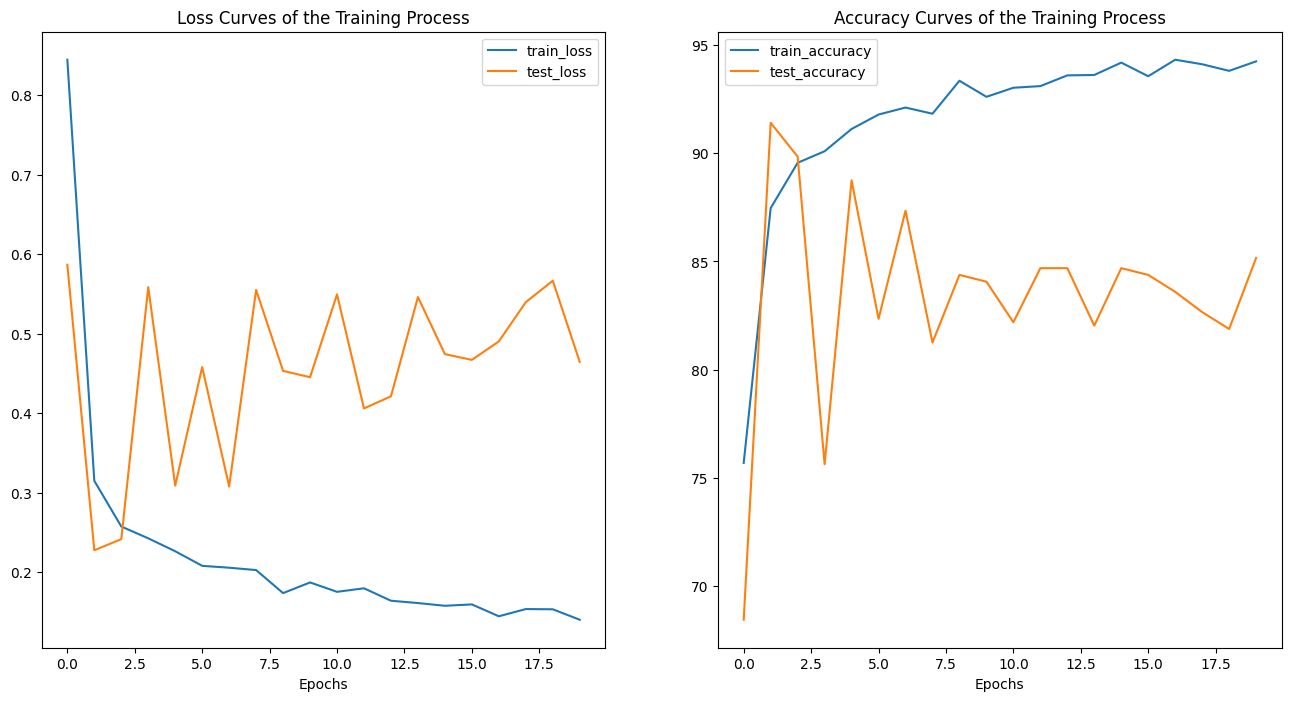

In [52]:
plot_loss_curves(model_v3_with_scheduler_results)

Let's try to add Batch Normalization Layer.

In [27]:
class PneumoniaModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*256*256,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_1(x))

In [28]:
class PneumoniaModelV2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*256*256,
                      out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_1(x))

In [68]:
pneumonia_model_v2_with_BatchNorm2d = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v2_with_BatchNorm2d

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [69]:
summary(pneumonia_model_v2_with_BatchNorm2d, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─BatchNorm2d: 2-2                  [1, 2, 512, 512]          4
│    └─ReLU: 2-3                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-4                       [1, 2, 512, 512]          38
│    └─BatchNorm2d: 2-5                  [1, 2, 512, 512]          4
│    └─ReLU: 2-6                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-7                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-8                      [1, 131072]               --
│    └─Linear: 2-9                       [1, 1]                    131,073
Total params: 131,175
Trainable params: 131,175
Non-trainable params: 0
Total mult

In [70]:
EPOCHS = 20

optimizer = torch.optim.Adam(pneumonia_model_v2_with_BatchNorm2d.parameters(), lr=0.001, betas=(0.9, 0.999))

from timeit import default_timer as timer

start_time = timer()

model_v2_with_BatchNorm2d_results = train(
    model = pneumonia_model_v2_with_BatchNorm2d,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.8607 Train Accuracy 91.7302 | Test Loss 2.4406 Test Accuracy 78.4375
Epoch 1 | Train Loss: 0.2905 Train Accuracy 95.2744 | Test Loss 1.2939 Test Accuracy 89.8438
Epoch 2 | Train Loss: 0.1512 Train Accuracy 97.5229 | Test Loss 2.0466 Test Accuracy 84.6875
Epoch 3 | Train Loss: 0.0713 Train Accuracy 98.5137 | Test Loss 5.2876 Test Accuracy 70.3125
Epoch 4 | Train Loss: 0.0807 Train Accuracy 98.4184 | Test Loss 1.6496 Test Accuracy 89.0625
Epoch 5 | Train Loss: 0.4221 Train Accuracy 95.8651 | Test Loss 4.2629 Test Accuracy 77.6562
Epoch 6 | Train Loss: 0.1178 Train Accuracy 98.4566 | Test Loss 2.7151 Test Accuracy 86.2500
Epoch 7 | Train Loss: 0.0179 Train Accuracy 99.5617 | Test Loss 4.1809 Test Accuracy 80.6250
Epoch 8 | Train Loss: 0.0043 Train Accuracy 99.8666 | Test Loss 4.0134 Test Accuracy 82.5000
Epoch 9 | Train Loss: 0.0013 Train Accuracy 99.9619 | Test Loss 3.0378 Test Accuracy 83.5938
Epoch 10 | Train Loss: 0.0030 Train Accuracy 99.9428 | Test Loss 3.950

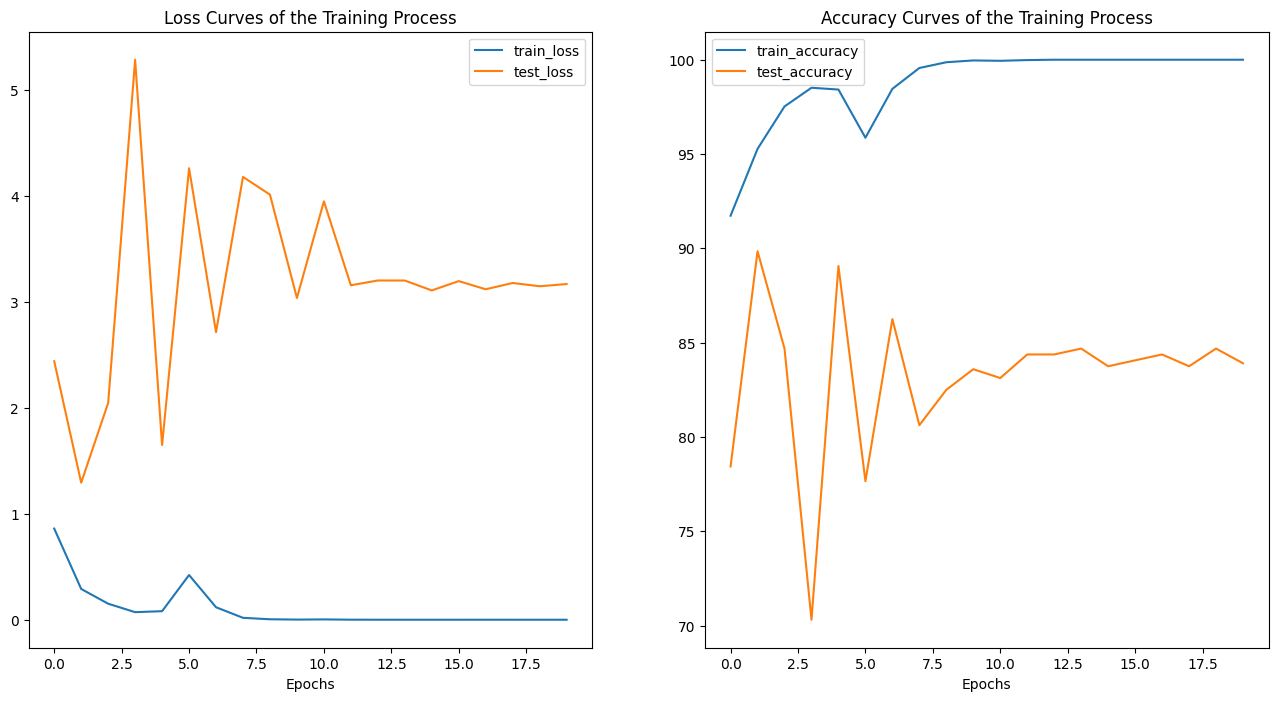

In [71]:
plot_loss_curves(model_v2_with_BatchNorm2d_results)

In [72]:
pneumonia_model_v3_with_BatchNorm2d = PneumoniaModelV1(
    input_shape=3,
    hidden_units=2,
    output_shape=1
).to(device)

pneumonia_model_v3_with_BatchNorm2d

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=1, bias=True)
  )
)

In [73]:
summary(pneumonia_model_v3_with_BatchNorm2d, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 2, 512, 512]          56
│    └─BatchNorm2d: 2-2                  [1, 2, 512, 512]          4
│    └─ReLU: 2-3                         [1, 2, 512, 512]          --
│    └─Conv2d: 2-4                       [1, 2, 512, 512]          38
│    └─BatchNorm2d: 2-5                  [1, 2, 512, 512]          4
│    └─ReLU: 2-6                         [1, 2, 512, 512]          --
│    └─MaxPool2d: 2-7                    [1, 2, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-8                      [1, 131072]               --
│    └─Linear: 2-9                       [1, 1]                    131,073
Total params: 131,175
Trainable params: 131,175
Non-trainable params: 0
Total mult

In [74]:
EPOCHS = 30

optimizer = torch.optim.Adam(pneumonia_model_v3_with_BatchNorm2d.parameters(), lr=0.001, betas=(0.9, 0.999))

from timeit import default_timer as timer

start_time = timer()

model_v3_with_BatchNorm2d_results = train(
    model = pneumonia_model_v3_with_BatchNorm2d,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 2.2284 Train Accuracy 78.6585 | Test Loss 1.9662 Test Accuracy 75.3125
Epoch 1 | Train Loss: 0.6413 Train Accuracy 85.3849 | Test Loss 0.8007 Test Accuracy 82.1875
Epoch 2 | Train Loss: 0.7296 Train Accuracy 84.2416 | Test Loss 0.5198 Test Accuracy 83.2812
Epoch 3 | Train Loss: 0.4782 Train Accuracy 86.0328 | Test Loss 0.3865 Test Accuracy 86.7188
Epoch 4 | Train Loss: 0.4155 Train Accuracy 86.6806 | Test Loss 0.4463 Test Accuracy 85.4688
Epoch 5 | Train Loss: 0.3188 Train Accuracy 88.2622 | Test Loss 0.3092 Test Accuracy 88.7500
Epoch 6 | Train Loss: 0.3434 Train Accuracy 87.8430 | Test Loss 0.4669 Test Accuracy 82.6562
Epoch 7 | Train Loss: 0.2572 Train Accuracy 89.9581 | Test Loss 0.6985 Test Accuracy 77.0312
Epoch 8 | Train Loss: 0.2271 Train Accuracy 91.0252 | Test Loss 0.5226 Test Accuracy 77.0312
Epoch 9 | Train Loss: 0.2061 Train Accuracy 91.4825 | Test Loss 0.3576 Test Accuracy 85.4688
Epoch 10 | Train Loss: 0.1997 Train Accuracy 91.7302 | Test Loss 0.347

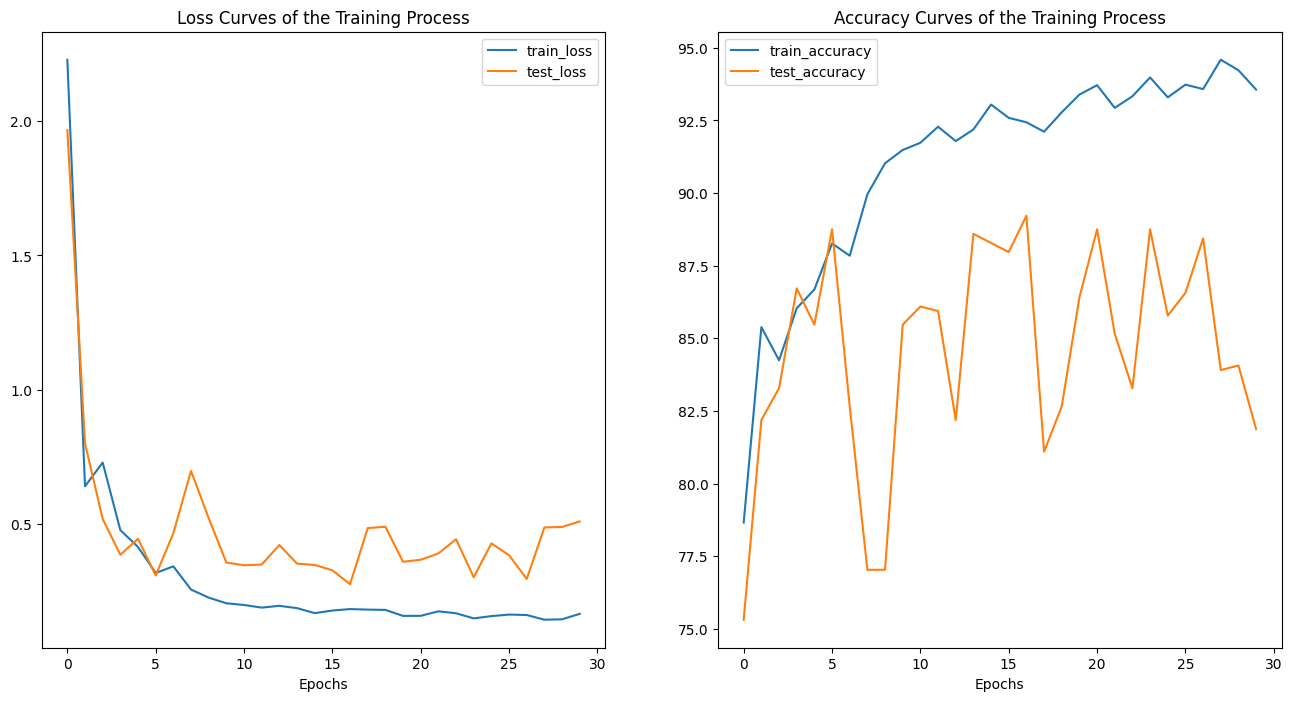

In [75]:
plot_loss_curves(model_v3_with_BatchNorm2d_results)

I'm more satisfied with the results having augmented data. Let's further modify it.

One more thing that comes into my mind is to use SGD optimizer instead of Adam.

In [68]:
## Let's modify the parent model class to contain Dropout2D Layers
class PneumoniaModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout2d(p=0.15),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*256*256, out_features=output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_1(x))

In [69]:
pneumonia_model_v3_with_BatchNorm2d_Dropout2D = PneumoniaModelV1(
    input_shape=1,
    hidden_units=4,
    output_shape=1
).to(device)

pneumonia_model_v3_with_BatchNorm2d_Dropout2D

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.15, inplace=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.25, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=1, bias=True)
  )
)

In [71]:
summary(pneumonia_model_v3_with_BatchNorm2d_Dropout2D, input_size=[1, 1, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 4, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 4, 512, 512]          40
│    └─BatchNorm2d: 2-2                  [1, 4, 512, 512]          8
│    └─ReLU: 2-3                         [1, 4, 512, 512]          --
│    └─Dropout2d: 2-4                    [1, 4, 512, 512]          --
│    └─Conv2d: 2-5                       [1, 4, 512, 512]          148
│    └─BatchNorm2d: 2-6                  [1, 4, 512, 512]          8
│    └─ReLU: 2-7                         [1, 4, 512, 512]          --
│    └─Dropout2d: 2-8                    [1, 4, 512, 512]          --
│    └─MaxPool2d: 2-9                    [1, 4, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-10                     [1, 262144]               --
│    └─Linear: 2

In [72]:
EPOCHS = 100

loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pneumonia_model_v3_with_BatchNorm2d_Dropout2D.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_v3_with_BatchNorm2d_Dropout2D_results = train_with_scheduler(
    model = pneumonia_model_v3_with_BatchNorm2d_Dropout2D,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_augmented,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6545 Train Accuracy 80.4116 | Test Loss 3.8840 Test Accuracy 79.3750 | Learning Rate 0.001
Epoch 1 | Train Loss: 3.7085 Train Accuracy 82.1265 | Test Loss 0.9438 Test Accuracy 90.4688 | Learning Rate 0.001
Epoch 2 | Train Loss: 1.7980 Train Accuracy 83.5556 | Test Loss 0.6169 Test Accuracy 91.2500 | Learning Rate 0.001
Epoch 3 | Train Loss: 1.3359 Train Accuracy 84.4893 | Test Loss 0.3289 Test Accuracy 89.0625 | Learning Rate 0.001
Epoch 4 | Train Loss: 0.7178 Train Accuracy 85.1753 | Test Loss 0.3766 Test Accuracy 84.3750 | Learning Rate 0.001
Epoch 5 | Train Loss: 0.5130 Train Accuracy 87.7858 | Test Loss 0.3793 Test Accuracy 81.7188 | Learning Rate 0.001
Epoch 6 | Train Loss: 0.3627 Train Accuracy 87.8239 | Test Loss 0.3644 Test Accuracy 87.1875 | Learning Rate 0.001
Epoch 7 | Train Loss: 0.3309 Train Accuracy 89.8056 | Test Loss 0.3605 Test Accuracy 85.7812 | Learning Rate 0.001
Epoch 8 | Train Loss: 0.2774 Train Accuracy 89.7294 | Test Loss 0.3331 Test Accu

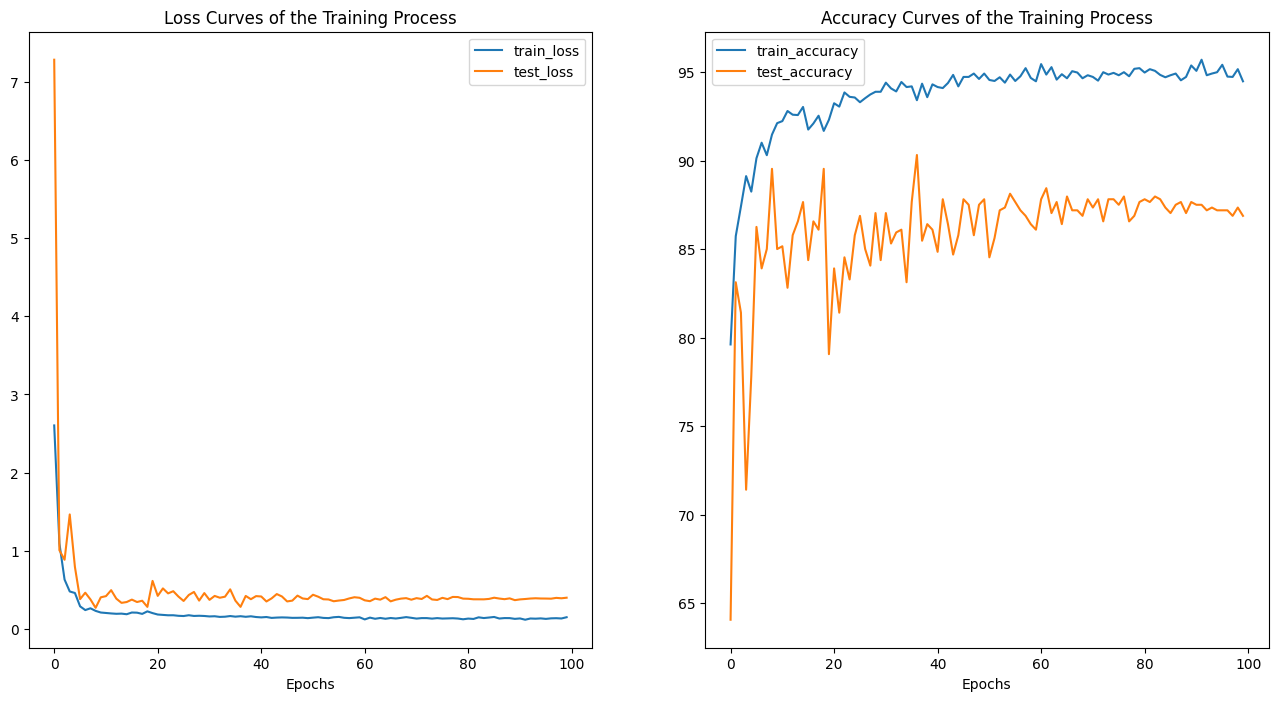

In [40]:
plot_loss_curves(model_v3_with_BatchNorm2d_Dropout2D_results)

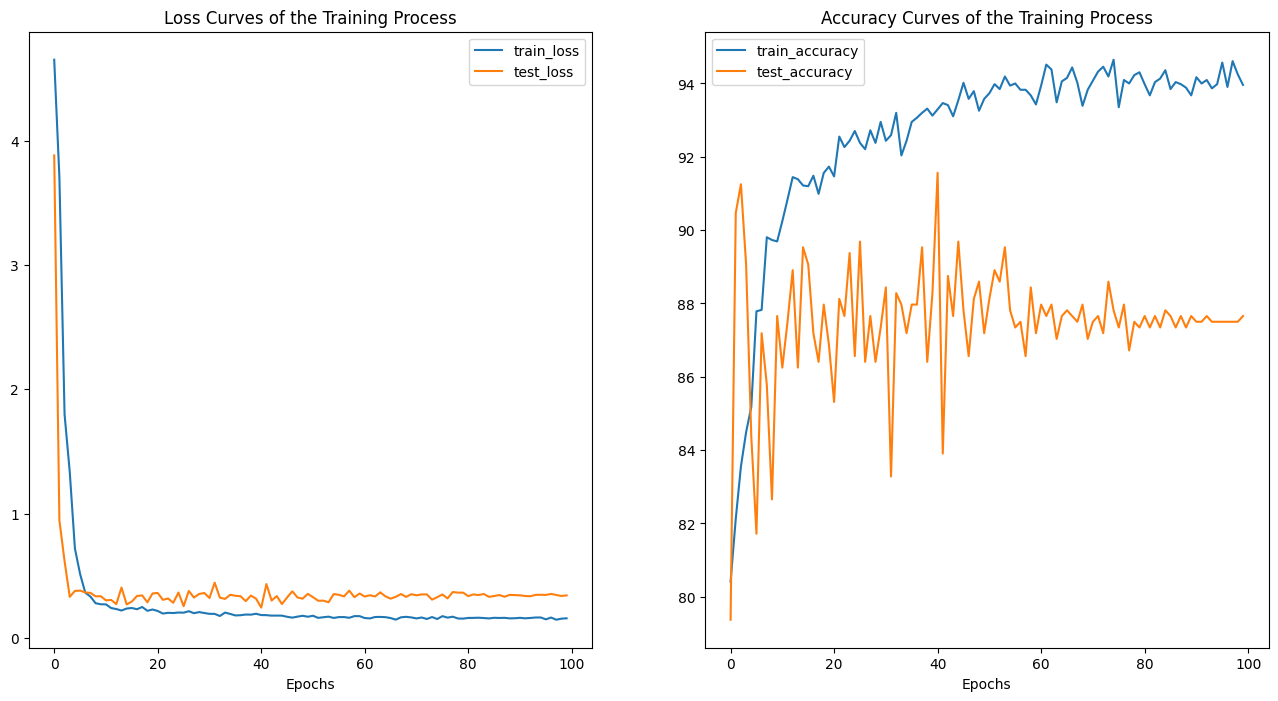

In [73]:
plot_loss_curves(model_v3_with_BatchNorm2d_Dropout2D_results)

In [74]:
pneumonia_model_v3_with_BatchNorm2d_Dropout2D.eval()

total_loss, total_accuracy = 0, 0

with torch.inference_mode():
    
    for batch, (X, y) in enumerate(test_dataloader_augmented):
        
        X, y = X.to(device), y.to(device)
        
        y_logits = pneumonia_model_v3_with_BatchNorm2d_Dropout2D(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        loss = loss_fun(y_logits, y.type(torch.float32))
        total_loss += loss.item()
        total_accuracy += accuracy_fun(y_true=y, y_pred=y_pred)
        
    total_loss = total_loss / len(test_dataloader_augmented)
    total_accuracy = total_accuracy / len(test_dataloader_augmented)
    
print(f"Final accuracy of the model is {total_accuracy:.4f} % with loss of {total_loss:.4f}")

Final accuracy of the model is 87.6562 % with loss of 0.3406


In [75]:
torch.save({
    "test_accuracy" : total_accuracy,
    "test_loss" : total_loss,
    "model_state_dict" : pneumonia_model_v3_with_BatchNorm2d_Dropout2D.state_dict()
}, "best_model.pth")

I had open this notebook after some days so I need to get my best model that I had trained above by using **torch.load()** functionality.

In [76]:
best_model = PneumoniaModelV1(
    input_shape=1, 
    hidden_units=4,
    output_shape=1
).to(device)

best_model

PneumoniaModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.15, inplace=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.25, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=1, bias=True)
  )
)

In [77]:
summary(best_model, input_size=(1, 1, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModelV1                         [1, 1]                    --
├─Sequential: 1-1                        [1, 4, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 4, 512, 512]          40
│    └─BatchNorm2d: 2-2                  [1, 4, 512, 512]          8
│    └─ReLU: 2-3                         [1, 4, 512, 512]          --
│    └─Dropout2d: 2-4                    [1, 4, 512, 512]          --
│    └─Conv2d: 2-5                       [1, 4, 512, 512]          148
│    └─BatchNorm2d: 2-6                  [1, 4, 512, 512]          8
│    └─ReLU: 2-7                         [1, 4, 512, 512]          --
│    └─Dropout2d: 2-8                    [1, 4, 512, 512]          --
│    └─MaxPool2d: 2-9                    [1, 4, 256, 256]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-10                     [1, 262144]               --
│    └─Linear: 2

In [78]:
x = torch.load("/kaggle/working/best_model.pth")

best_model.load_state_dict(x["model_state_dict"])
best_model.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-0.0369, -0.1844,  0.2831],
                        [ 0.1122, -0.1389,  0.3664],
                        [ 0.1529,  0.2951,  0.1890]]],
              
              
                      [[[ 0.3165,  0.3996,  0.1857],
                        [-0.1812,  0.3240, -0.1730],
                        [-0.0547,  0.2236,  0.1181]]],
              
              
                      [[[ 0.1472, -0.1349,  0.1529],
                        [ 0.2692,  0.2567,  0.2268],
                        [-0.0961, -0.3426, -0.2854]]],
              
              
                      [[[ 0.3320,  0.1660, -0.1002],
                        [ 0.1266,  0.1978, -0.1891],
                        [-0.2081, -0.1468, -0.1881]]]], device='cuda:0')),
             ('conv_block_1.0.bias',
              tensor([-0.3445, -0.1475, -0.0621,  0.1305], device='cuda:0')),
             ('conv_block_1.1.weight',
              tensor([0.9940, 0.9898, 0.9333, 1.1495]

Let's make prediction on a custom X-ray image.

In [17]:
custom_image_path = "/kaggle/input/pneumonia-disease-dataset/chest_xray/test/PNEUMONIA/BACTERIA-1351146-0001.jpeg"

custom_image_path

'/kaggle/input/pneumonia-disease-dataset/chest_xray/test/PNEUMONIA/BACTERIA-1351146-0001.jpeg'

In [19]:
custom_image = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image tensor shape: {custom_image.shape}\n")
print(f"Custom image tensor dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[35, 36, 36,  ..., 16, 17, 17],
         [37, 37, 38,  ..., 16, 16, 16],
         [39, 39, 40,  ..., 14, 14, 14],
         ...,
         [28, 28, 28,  ..., 30, 30, 30],
         [28, 28, 28,  ..., 30, 30, 30],
         [28, 28, 28,  ..., 30, 30, 30]]], dtype=torch.uint8)

Custom image tensor shape: torch.Size([1, 856, 1040])

Custom image tensor dtype: torch.uint8


In [20]:
custom_image = custom_image.type(torch.float32)

print(f"Custom image tensor dtype: {custom_image.dtype}")

Custom image tensor dtype: torch.float32


(-0.5, 1039.5, 855.5, -0.5)

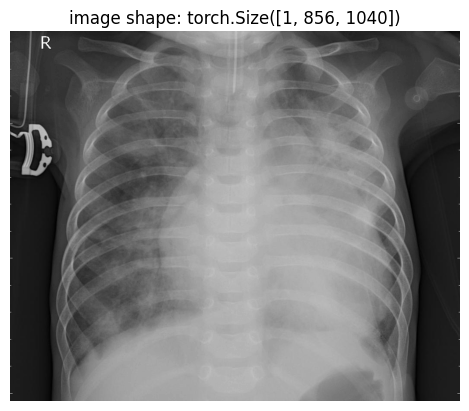

In [23]:
## Let's plot the given image to see what it looks like
plt.imshow(custom_image.permute(1, 2, 0), cmap="gray")
plt.title(f"image shape: {custom_image.shape}")
plt.axis(False)

Let's divide the value of the pixels by 255 to make it between 0 to 1.

In [25]:
custom_image = custom_image / 255.0

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image tensor shape: {custom_image.shape}\n")
print(f"Custom image tensor dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1373, 0.1412, 0.1412,  ..., 0.0627, 0.0667, 0.0667],
         [0.1451, 0.1451, 0.1490,  ..., 0.0627, 0.0627, 0.0627],
         [0.1529, 0.1529, 0.1569,  ..., 0.0549, 0.0549, 0.0549],
         ...,
         [0.1098, 0.1098, 0.1098,  ..., 0.1176, 0.1176, 0.1176],
         [0.1098, 0.1098, 0.1098,  ..., 0.1176, 0.1176, 0.1176],
         [0.1098, 0.1098, 0.1098,  ..., 0.1176, 0.1176, 0.1176]]])

Custom image tensor shape: torch.Size([1, 856, 1040])

Custom image tensor dtype: torch.float32


We just need to convert the shape of the image to [1, 512, 512] to make it compatible with our model.

In [28]:
custom_image_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
])

transformed_image = custom_image_transforms(custom_image)

print(f"Shape of the original image: {custom_image.shape}\n")
print(f"Shape of the transformed image: {transformed_image.shape}")

Shape of the original image: torch.Size([1, 856, 1040])

Shape of the transformed image: torch.Size([1, 512, 512])


Let's use PIL libraries Image() method to get the image.

(-0.5, 1039.5, 855.5, -0.5)

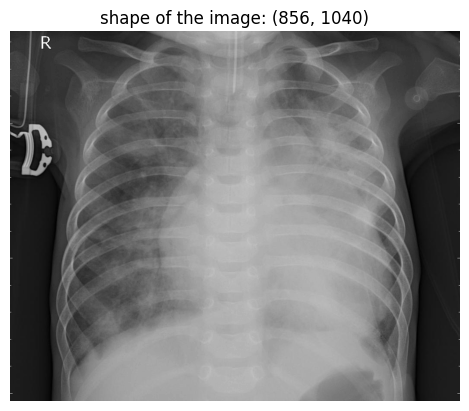

In [80]:
custom_image = Image.open(custom_image_path)

image_array = np.asarray(custom_image)

plt.imshow(image_array, cmap="gray")
plt.title(f"shape of the image: {image_array.shape}")
plt.axis(False)

In [82]:
custom_image_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.ToTensor()
])

transformed_image = custom_image_transforms(custom_image)

print(f"Image tensor: \n{transformed_image}\n")
print(f"Shape of the transformed image: {transformed_image.shape}\n")
print(f"Image tensor datatype: {transformed_image.dtype}")

Image tensor: 
tensor([[[0.1412, 0.1451, 0.1529,  ..., 0.0549, 0.0627, 0.0667],
         [0.1529, 0.1569, 0.1608,  ..., 0.0588, 0.0588, 0.0549],
         [0.1647, 0.1686, 0.1725,  ..., 0.0627, 0.0588, 0.0510],
         ...,
         [0.1098, 0.1098, 0.1098,  ..., 0.1176, 0.1176, 0.1176],
         [0.1098, 0.1098, 0.1098,  ..., 0.1176, 0.1176, 0.1176],
         [0.1098, 0.1098, 0.1098,  ..., 0.1176, 0.1176, 0.1176]]])

Shape of the transformed image: torch.Size([1, 512, 512])

Image tensor datatype: torch.float32


Also we need to add one more extra dimension because our model expects the dimensions in the form of [batch_size, channel_number, height, width].

In [83]:
transformed_image = transformed_image.unsqueeze(dim=0)

print(f"Shape of the image tensor: {transformed_image.shape}")

Shape of the image tensor: torch.Size([1, 1, 512, 512])


In [84]:
## Let's make prediction on top of our custom image
best_model.eval()

with torch.inference_mode():
    transformed_image = transformed_image.to(device)
    
    y_logits = best_model(transformed_image).squeeze()
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_prob)
    
if y_pred_prob >= 0.9:
    print("Pneumonia detected!")
else:
    print("The person is healthy :)")
    
print(f"Predicted class: {y_pred}")

Pneumonia detected!
Predicted class: 1.0


Let's try it out for a negative case.

In [85]:
custom_image_path = "/kaggle/input/pneumonia-disease-dataset/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg"

custom_image_path

'/kaggle/input/pneumonia-disease-dataset/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg'

(-0.5, 1983.5, 1558.5, -0.5)

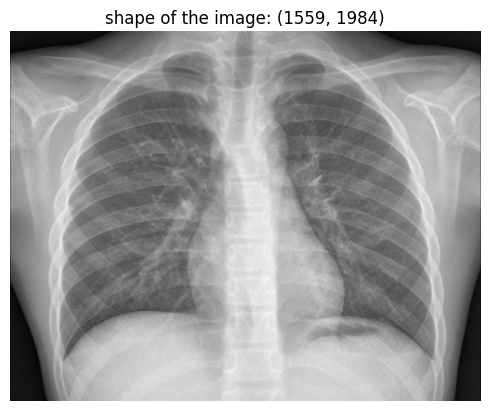

In [86]:
custom_image = Image.open(custom_image_path)

image_array = np.asarray(custom_image)

plt.imshow(image_array, cmap="gray")
plt.title(f"shape of the image: {image_array.shape}")
plt.axis(False)

In [87]:
custom_image_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.ToTensor()
])

transformed_image = custom_image_transforms(custom_image)

print(f"Image tensor: \n{transformed_image}\n")
print(f"Shape of the transformed image: {transformed_image.shape}\n")
print(f"Image tensor datatype: {transformed_image.dtype}")

Image tensor: 
tensor([[[0.0588, 0.0784, 0.0824,  ..., 0.0941, 0.0980, 0.0784],
         [0.0627, 0.0745, 0.0784,  ..., 0.0980, 0.0941, 0.0745],
         [0.0627, 0.0745, 0.0784,  ..., 0.0941, 0.0941, 0.0706],
         ...,
         [0.0706, 0.0784, 0.0784,  ..., 0.1059, 0.1020, 0.0863],
         [0.0706, 0.0784, 0.0784,  ..., 0.1020, 0.0980, 0.0863],
         [0.0667, 0.0824, 0.0863,  ..., 0.1020, 0.1020, 0.0824]]])

Shape of the transformed image: torch.Size([1, 512, 512])

Image tensor datatype: torch.float32


In [88]:
transformed_image = transformed_image.unsqueeze(dim=0)

print(f"Shape of the image tensor: {transformed_image.shape}")

Shape of the image tensor: torch.Size([1, 1, 512, 512])


In [90]:
## Let's make prediction on top of our custom image
best_model.eval()

with torch.inference_mode():
    transformed_image = transformed_image.to(device)
    
    y_logits = best_model(transformed_image).squeeze()
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_prob)
    
if y_pred_prob >= 0.3:
    print("Pneumonia detected!")
else:
    print("The person is healthy :)")
    
print(f"Predicted class: {y_pred}")

The person is healthy :)
Predicted class: 0.0


#### Yeah! So we're able to achieve our objective of this notebook.
Our objective is to get a CNN that can accurately predict whether a given X-Ray image is of pneumonia infected patient or not.